In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
import pyhomogeneity as hg

- [x] 1.Чтение данных и объединение таблиц с данными о регистрациях
- [x] 2.Предобработка данных
    - [x] 2.1 Регистрации
    - [x] 2.2 Займы
- [x] 3.Динамика основных показателей по месяцам
    - [x] 3.1 Группировка данных о регистарциях
    - [x] 3.2 Группировка данных о займах
    - [x] 3.3 Объеденение данных в обну таблицу
    - [x] 3.4 Визуализация
- [x] 4.Сколько времени проходит с момента начала регистрации до оформления первого займа
- [x] 5.Группировка займов и суммы пользователям. Визуализация + расчет персентилей
- [x] 6.Исследвание срока займа (план, факт) + динамика по месяцам
    - [x] 6.1 Запрашиваемые и фактические значения займов
    - [x] 6.2 Распределение показателей, среднее значение, медиана, мода
    - [x] 6.3 Динамка планового и фактического срока пользования деньгами
- [x] 7.Категоризация займов по реальному сроку пользования деньгами
- [x] 8.Исследование суммы займов
    - [x] 8.1 Базовые данные о сумме займов
    - [x] 8.2 Динамика измениня средней суммы займа
- [x] 9.Когортный анализ
    - [x] 9.1 User Retention
    - [x] 9.2 Ср.кол-во займов нарастающим итогом
    - [x] 9.3 Ср.сумма займа нарастающим итогом
    - [x] 9.4 ARPU
    - [x] 9.5 Ретеншен капитала
    - [x] 9.6 NPL "наоборот"
    - [x] 9.7 Накопительное среднее количество дней пользование кредитом на уникального клиента
- [ ] Категоризация по первому займу

ЗАКИНУТЬ ИДЕЮ ПРО БЛОКИРОВКИ

### 1. Чтение данных и объединение таблиц с данными о регистрациях

In [2]:
# читаем данные
regs1 = pd.read_excel('regs1.xlsx')
regs2 = pd.read_excel('regs2.xlsx')
loans = pd.read_excel('loans.xlsx')

In [3]:
# т.к данные с регистрациями предоставлены в 2ух файлах нам необходимо объеденить их в 1
regs = regs1.append(regs2, ignore_index=True)

### 2. Предобработка данных

#### 2.1 Регистрации

In [4]:
# посмотрим на общую информацию
regs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1685056 entries, 0 to 1685055
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   cid              1685056 non-null  int64         
 1   reg_date         1685056 non-null  datetime64[ns]
 2   is_reg_complete  1685056 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 38.6 MB


In [5]:
# изучим срез данных
regs.sample(5)

,cid,reg_date,is_reg_complete
1076309,4092529,2019-12-20,0
1280698,4301419,2020-03-19,1
988701,4004456,2019-11-14,0
297298,3173930,2019-03-14,1
648767,3610086,2019-06-17,1


<div class="alert alert-block alert-info">
<ul>
    <li>cid - id клиента
    <li>reg_date - дата начала регистрации
    <li>is_reg_complete - отметка о завершени регистрации
</ul>
</div>

In [6]:
# проверим таблицу на наличие пропусков
display(regs.isna().sum())

cid                0
reg_date           0
is_reg_complete    0
dtype: int64

In [7]:
# также проверим данные на наличие дубликатов
display(regs.duplicated().sum())

0

<div class="alert alert-block alert-info">
Пропусков и дублей нет, идем дальше
</div>

#### 2.2 Займы

In [8]:
# посмотрим на общую информацию
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465315 entries, 0 to 465314
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   cid         465315 non-null  int64         
 1   start_date  448305 non-null  datetime64[ns]
 2   value       465315 non-null  float64       
 3   term        465315 non-null  int64         
 4   status      465315 non-null  object        
 5   end_date    332380 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 21.3+ MB


In [9]:
# изучим срез данных
loans.sample(5)

,cid,start_date,value,term,status,end_date
374289,4378975,2020-10-08,5000.0,40,Просрочен,NaT
390852,4428033,2020-06-15,11500.0,40,Погашен,2020-08-30
126284,3328295,2019-10-08,13320.0,56,Погашен,2019-12-03
411461,4487155,2020-09-24,3500.0,15,Погашен,2020-10-07
211713,3720360,2019-10-03,9000.0,42,Просрочен,NaT


<div class="alert alert-block alert-info">
<ul>
    <li>cid - id клиента
    <li>start_date - дата начала займа
    <li>value - сумма займа
    <li>term - срок займа
    <li>status - статус займа на момент выгрузки данных
    <li>end_ts - дата окончания займа
</ul>
</div>

In [10]:
# проверим таблицу на наличие пропусков
loans.isna().sum()

cid                0
start_date     17010
value              0
term               0
status             0
end_date      132935
dtype: int64

In [11]:
# также проверим данные на наличие дубликатов
loans.duplicated().sum()

1872

<div class="alert alert-block alert-info">
    <li> нужно избавиться от пропусков в столбце start_date т.к займ без даты начала не имеет для нас ценности
    <li> с пропусками в end_date ничего делать будем т.к это скорее всего еще не закрытые займы
    <li> также избавимся от дублей
</div>

In [12]:
# удаляем пропуски из столбца start_date
loans.dropna(subset=['start_date'], inplace=True)

# проверяем
loans.isna().sum()

cid                0
start_date         0
value              0
term               0
status             0
end_date      115925
dtype: int64

In [13]:
# теперь избавимся от дублей
loans.drop_duplicates(inplace=True)
loans.duplicated().sum()

0

### 3.Динамика основных показателей по месяцам

#### 3.1 Группировка данных о регистарциях

In [14]:
# добавим в таблицу regs столбец reg_month - месяц регистрации пользователя
regs['reg_month'] = regs['reg_date'].astype('datetime64[M]')

# проверяем
regs.sample(5)

,cid,reg_date,is_reg_complete,reg_month
584346,3531887,2019-05-07,1,2019-05-01
1150599,4169047,2020-01-20,1,2020-01-01
176700,3035331,2019-02-11,1,2019-02-01
558379,3498457,2019-05-02,0,2019-05-01
1405759,4426690,2020-06-14,1,2020-06-01


In [15]:
# сгруппируем данные по месяцам, посчитаем общее кол-во регистраци и кол-во успешных регистраций
regs_by_month = regs.groupby(by='reg_month').agg({'cid': 'nunique', 'is_reg_complete': 'sum'})
regs_by_month.columns = ['total_regs', 'success_regs']

# смотрим
regs_by_month

,total_regs,success_regs
reg_month,,
2019-01-01,133531,87889
2019-02-01,111882,69732
2019-03-01,144595,89224
2019-04-01,162872,99949
2019-05-01,76872,51432
2019-06-01,60268,41303
2019-07-01,100521,66543
2019-08-01,90094,58371
2019-09-01,20201,14530


#### 3.2 Группировка данных о займах

In [16]:
# добавим в таблицу loans столбец с месяцев получения займа- loan_month
loans['loan_month'] = loans['start_date'].astype('datetime64[M]')

# проверяем
loans.sample(5)

,cid,start_date,value,term,status,end_date,loan_month
309966,4125589,2020-08-23,20000.0,56,Погашен,2020-10-18,2020-08-01
15610,2877585,2019-08-21,30000.0,168,Погашен,2020-08-06,2019-08-01
126222,3328097,2019-04-05,14500.0,30,Погашен,2019-04-28,2019-04-01
328864,4195231,2020-07-10,35000.0,168,На реструктуризации,NaT,2020-07-01
199198,3670093,2020-11-08,3450.0,29,Погашен,2020-12-02,2020-11-01


In [17]:
# для каждого юзера найдем месяц первого займа
new_loans_by_month = loans.sort_values(by=['cid', 'start_date']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# сгруппируем данные по месяцам и подсчитаем кол-во уникальны займов
new_loans_by_month = new_loans_by_month.groupby(by='loan_month').agg({'cid': 'count'})
new_loans_by_month.columns = ['new_loans']

# проверяем
new_loans_by_month

,new_loans
loan_month,
2019-01-01,7957
2019-02-01,8879
2019-03-01,12222
2019-04-01,13328
2019-05-01,7258
2019-06-01,4995
2019-07-01,10059
2019-08-01,8585
2019-09-01,4140


In [18]:
# теперь посчитаем общее кол-во займов по месяцам
total_loans_by_month = loans.groupby(by='loan_month').agg({'cid': 'count'})
total_loans_by_month.columns = ['total_loans']

# проверяем
total_loans_by_month

,total_loans
loan_month,
2019-01-01,9157
2019-02-01,13419
2019-03-01,20770
2019-04-01,23864
2019-05-01,16360
2019-06-01,13091
2019-07-01,19330
2019-08-01,19683
2019-09-01,13197


In [19]:
# объеденим таблицы total_loans_by_month и new_loans_by_month
loans_by_month = pd.merge(total_loans_by_month, new_loans_by_month, on='loan_month')

# рассчитаем кол-во повторных займов
loans_by_month['repeated_loans'] = loans_by_month['total_loans'] - loans_by_month['new_loans']

# проверяем
loans_by_month

,total_loans,new_loans,repeated_loans
loan_month,,,
2019-01-01,9157,7957,1200
2019-02-01,13419,8879,4540
2019-03-01,20770,12222,8548
2019-04-01,23864,13328,10536
2019-05-01,16360,7258,9102
2019-06-01,13091,4995,8096
2019-07-01,19330,10059,9271
2019-08-01,19683,8585,11098
2019-09-01,13197,4140,9057


#### 3.3 Объеденение данных в обну таблицу

In [20]:
# объеденяем данные
total_grouped_data = pd.merge(regs_by_month, loans_by_month, left_index=True, right_index=True)

# проверяем
total_grouped_data

,total_regs,success_regs,total_loans,new_loans,repeated_loans
2019-01-01,133531,87889,9157,7957,1200
2019-02-01,111882,69732,13419,8879,4540
2019-03-01,144595,89224,20770,12222,8548
2019-04-01,162872,99949,23864,13328,10536
2019-05-01,76872,51432,16360,7258,9102
2019-06-01,60268,41303,13091,4995,8096
2019-07-01,100521,66543,19330,10059,9271
2019-08-01,90094,58371,19683,8585,11098
2019-09-01,20201,14530,13197,4140,9057
2019-10-01,47373,35325,14844,6106,8738


#### 3.4 Визуализация

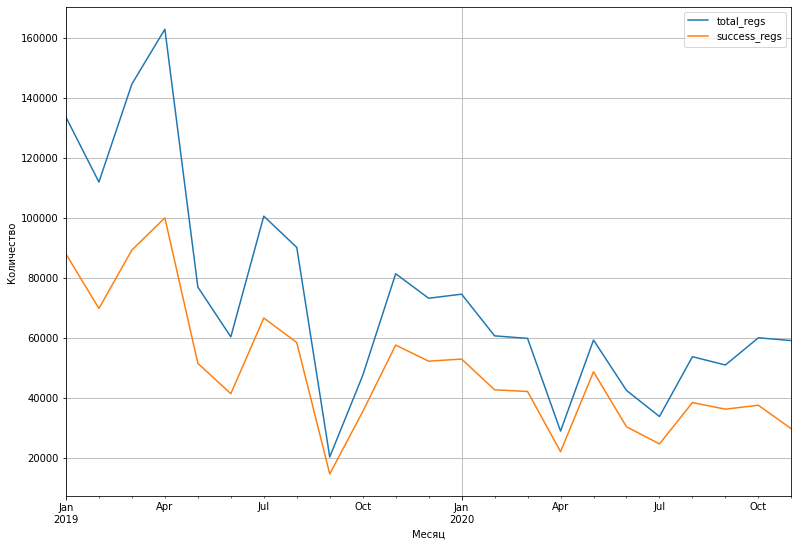

In [21]:
# динамика регистраций по месяцам
total_grouped_data[['total_regs', 'success_regs']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

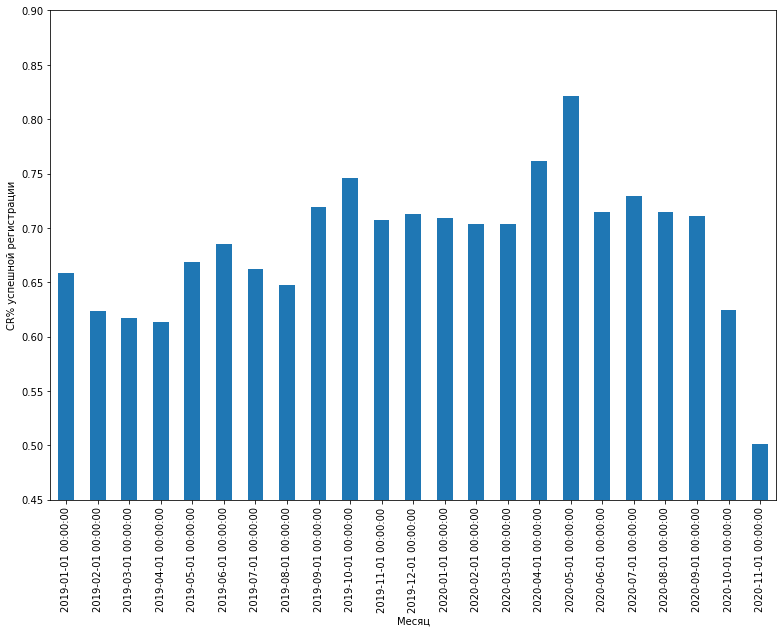

In [22]:
# динамика конверсии из все регистраций в успешные по месяцам
(total_grouped_data['success_regs'] / total_grouped_data['total_regs']).plot(figsize=(13, 9), kind='bar');
plt.ylim(0.45, 0.9)
plt.xlabel('Месяц');
plt.ylabel('CR% успешной регистрации');

<div class="alert alert-block alert-info">
<b>Вывод:</b>
    <ul>
        <li> кол-во завершенных регистраций повторяет график общего кол-ва регистраций. 
        <li> конверсия из регистрации в успешную регистрацию колеблется в диапазоне от 62% до 72%, но иногда происходят скачки
    </ul>
</div>

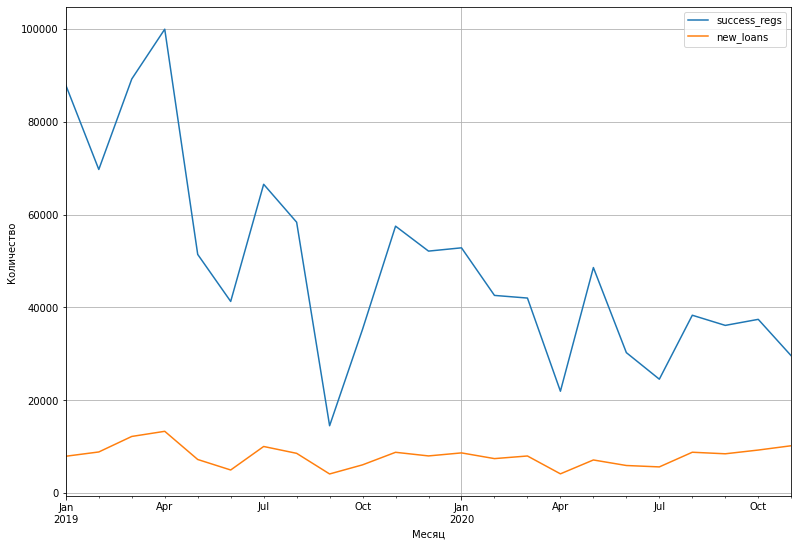

In [23]:
# теперь на одном графике сравним динамику успешных регистраций и новых займов
total_grouped_data[['success_regs', 'new_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

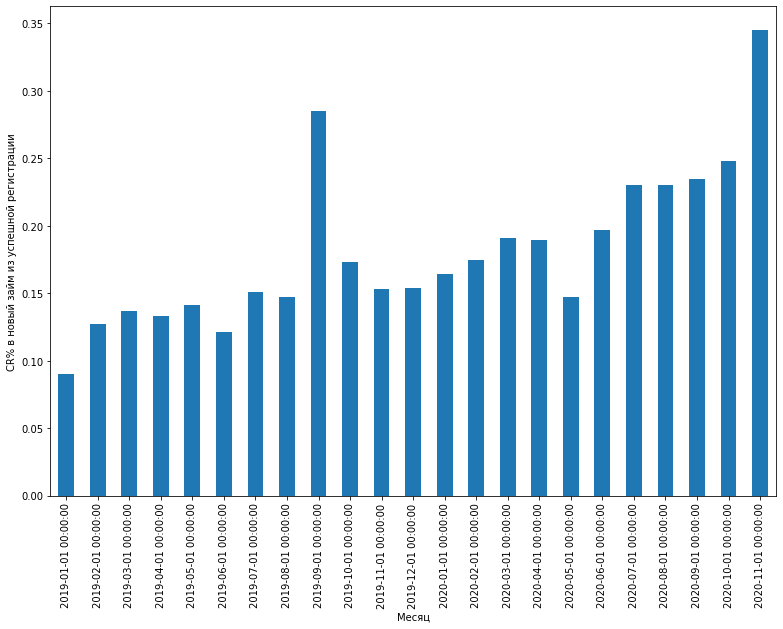

In [24]:
# а также посмотрим на конверсию в динамике
(total_grouped_data['new_loans'] / total_grouped_data['success_regs']).plot(figsize=(13, 9), kind='bar');
plt.xlabel('Месяц');
plt.ylabel('CR% в новый займ из успешной регистрации');

<div class="alert alert-block alert-info">
<b>Вывод:</b>
    <ul>
        <li> кол-во успешных регистраций на протяжении всего периода снижается
        <li> при этом мы видим, что новые выдачи повторяют график, но перепады не настолько значимы
        <li> частично это можно объяснить тем, что менялась форма регистрации и "успешной" в разные моменты времени регистрация оценивается по-разному
        <li> в последние 6 месяцев анализируемого периода конверсия находится на х1.5-2 от уровня предыдущего периода
    </ul>
</div>

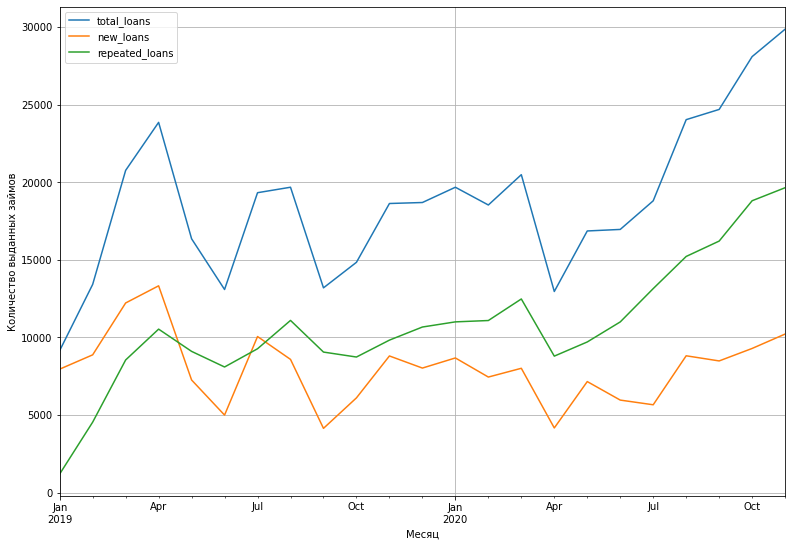

In [25]:
# посмотрим на долю разных типов займов в динамике
total_grouped_data[['total_loans', 'new_loans', 'repeated_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество выданных займов');

<div class="alert alert-block alert-info">
<b>Вывод:</b>
    <ul>
        <li> даже с учетом весеннего локдауна практически нет просадки в цифрых
        <li> с апреля 2020 наблюдается стабильный рост показателей как новых так и повторных выдач
        <li> доля повторных займов составляет около 66% и растет быстрее новых - это хорошо
    </ul>
</div>

### 4. Сколько времени проходит с момента начала регистрации до оформления первого займа

In [26]:
# для начала из таблицы loans нам нужно получить для каждого юзера данные о его первом займе
first_loan_ts = loans.sort_values(by=['cid', 'start_date']).groupby(by='cid').agg({'start_date': 'first'}).reset_index()
first_loan_ts.columns=['cid', 'first_loan_date']

# проверяем
first_loan_ts.head()

,cid,first_loan_date
0,2825209,2019-01-01
1,2825218,2019-01-01
2,2825225,2019-03-30
3,2825230,2020-09-12
4,2825232,2019-07-27


In [27]:
# теперь добавим эти данные в таблицу с регистрациями
time_to_loan = pd.merge(regs, first_loan_ts, how='left', on='cid')

# посмотрим на случайные 20 записей из получившейся таблицы
time_to_loan.sample(20)

,cid,reg_date,is_reg_complete,reg_month,first_loan_date
808557,3794761,2019-08-06,0,2019-08-01,NaT
891212,3892596,2019-09-08,1,2019-09-01,NaT
946378,3961820,2019-10-31,1,2019-10-01,NaT
1562410,4583394,2020-09-29,0,2020-09-01,NaT
440590,3354594,2019-04-09,0,2019-04-01,NaT
427055,3337434,2019-04-06,1,2019-04-01,NaT
1267166,4287869,2020-03-14,0,2020-03-01,NaT
210634,3074084,2019-02-20,1,2019-02-01,NaT
23643,2852637,2019-01-07,1,2019-01-01,NaT
1084135,4100397,2019-12-24,0,2019-12-01,NaT


<div class="alert alert-block alert-info">
<b>Важно:</b> во многих строках столбца start_loan появились значения NaT. Это говорит о том, что клиент начал регистрацию, но в итоге ни одного займа не получил. Избавимся от этих строк</div>

In [28]:
# удаляем лишние строки
time_to_loan.dropna(subset=['first_loan_date'], inplace=True)

# добавим в таблицу новый столбец с кол-во дней с начала регистрации до первого займа
time_to_loan['days_to_loan'] = (time_to_loan['first_loan_date'] - time_to_loan['reg_date']).dt.days

time_to_loan.sample(10)

,cid,reg_date,is_reg_complete,reg_month,first_loan_date,days_to_loan
229932,3095418,2019-02-25,1,2019-02-01,2019-07-29,154
606194,3557464,2019-05-15,1,2019-05-01,2019-05-15,0
271063,3142246,2019-03-08,1,2019-03-01,2019-03-08,0
1379588,4400508,2020-05-28,1,2020-05-01,2020-05-28,0
1632853,4654063,2020-11-04,1,2020-11-01,2020-11-04,0
1625215,4646418,2020-10-31,1,2020-10-01,2020-10-31,0
89571,2931109,2019-01-22,1,2019-01-01,2020-06-30,525
137890,2990642,2019-02-01,1,2019-02-01,2019-02-02,1
1066083,4082244,2019-12-16,1,2019-12-01,2020-02-11,57
441578,3355694,2019-04-09,1,2019-04-01,2019-04-09,0


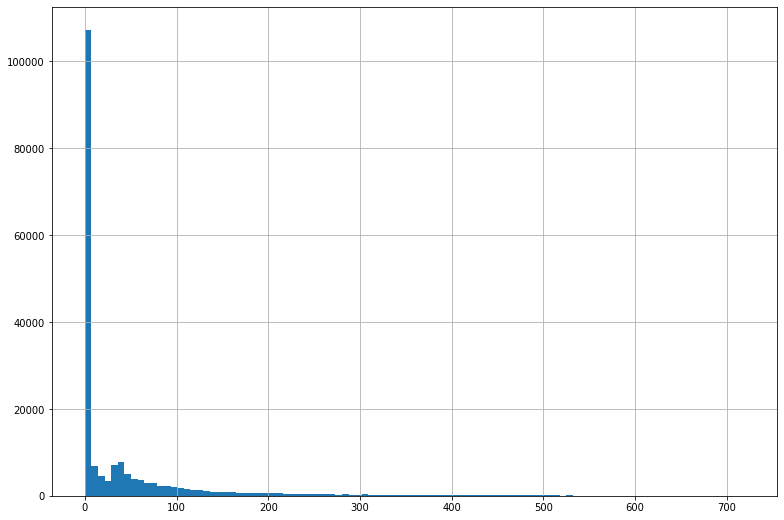

In [29]:
# построим гистограмму
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=100);

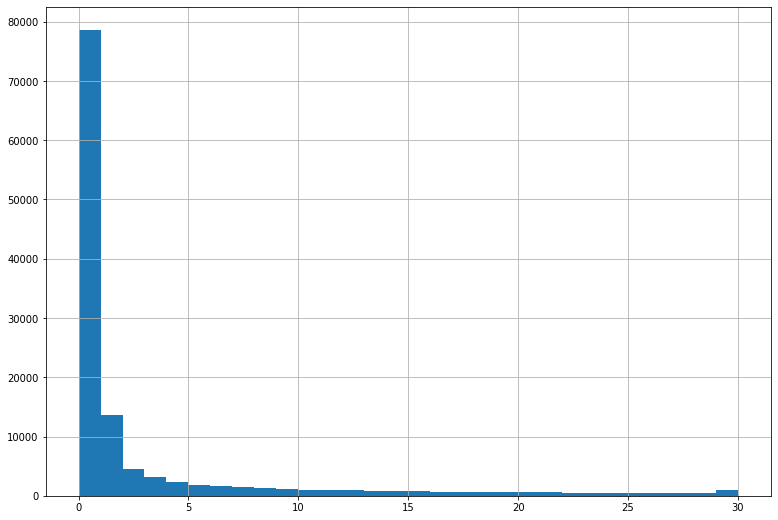

In [30]:
# львиная доля значений лежит в диапазоне от 0 до 30 дней, ограничим гистограмму этими значениями
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=30, range=(0, 30));

In [31]:
# посмотрим на ТОП10 значений
time_to_loan['days_to_loan'].value_counts().head(10)

0     78616
1     13644
2      4490
3      3248
4      2284
5      1817
6      1622
7      1468
32     1324
8      1299
Name: days_to_loan, dtype: int64

In [32]:
# 50, 70, 90 персентили
np.percentile(time_to_loan['days_to_loan'], [50, 70, 90])

array([  2.,  37., 132.])

<div class="alert alert-block alert-info">
<b>Вывод:</b>
    <ul>
        <li> львиная доля клиентов получают свой первый заем в день регистрации
        <li> у 50% пользователей уходит более 2ух дней с момента регистрации до момента займа
        <li> у 30% пользователей уходит более 37ми дней с момента регистрации до момента займа
        <li> у 10% пользователей уходит более 132ух дней с момента регистрации до момента займа
        <li> кол-во выдач на следующий день относительно большое, но это в т.ч. может быть связано с займами, которые оформляются в вечернее время и выдаются уже на следующий день
        <li> есть небольшой скачок на 32 день. Скорее всего это связано с разблокировкой спустя 30 дней
        <li> чем дальше от времени регистрации тем меньше шанс, что клиент оформит свой первый заем
        <li> в качестве рекомендации - нужно стараться максимально быстро конвертировать регистрацию в первый заем
    </ul>
</div>

### 5. Группировка займов и суммы пользователям. Визуализация + расчет персентилей

In [33]:
# группируем данные по пользователям, считам кол-во займов и сумму займов
grouped_by_cid = loans.groupby(by='cid').agg({'cid': 'count', 'value': 'sum', 'term': 'sum'})
grouped_by_cid.columns=['n_loans', 'c_value', 'c_term']

# проверяем
grouped_by_cid.head(10)

,n_loans,c_value,c_term
cid,,,
2825209,20,219400.0,529
2825218,7,115000.0,147
2825225,6,21200.0,118
2825230,10,51800.0,227
2825232,1,33000.0,168
2825251,1,3500.0,18
2825254,1,5000.0,20
2825261,1,5175.0,23
2825277,2,8000.0,50


In [34]:
x_values = x_values = pd.Series(range(0,len(grouped_by_cid)))

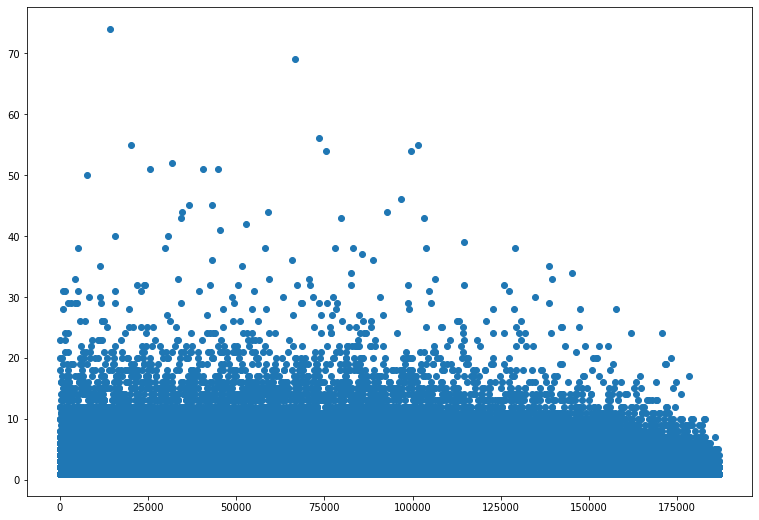

In [35]:
# точечная диаграмма распределения кол-ва займой по пользователям
plt.figure(figsize=(13, 9));
plt.scatter(x_values, grouped_by_cid['n_loans']);

In [36]:
# 70, 80, 90 персентили
np.percentile(grouped_by_cid['n_loans'], [70, 80, 90, 95, 99])

array([ 2.,  3.,  5.,  7., 12.])

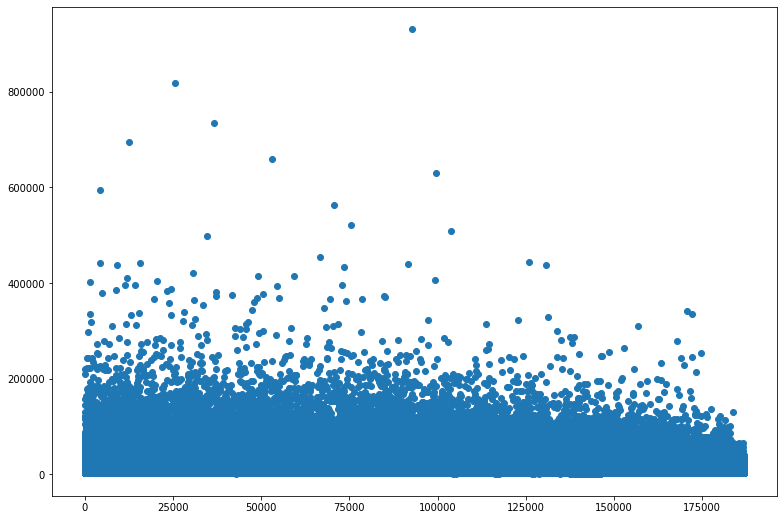

In [37]:
# точечная диаграмма распределения кол-ва дней пользования кредитом по пользователям
plt.figure(figsize=(13, 9));
plt.scatter(x_values, grouped_by_cid['c_value']);

In [38]:
# 70, 80, 90 персентили
np.percentile(grouped_by_cid['c_value'], [70, 80, 90, 95, 99])

array([ 24500. ,  34020.2,  51146. ,  70400. , 125000. ])

<div class="alert alert-block alert-info">
<b>Вывод:</b>
    <ul>
        <li> 70% клиентов берут до 2 займов, 80% до 3 займов и 90% до 5 займов
        <li> 70% клиентов берут займы на сумму до 24500, 80% на сумму до 34000 и 90% на сумму до 51150
        <li> небольшая визуальная дуга слева направо на точечных графиках получается потому, что данные отсортированы по возрастанию cid. Т.е слева более старые клиенты, а правее - "свежие".
        <li> и по кол-ву займов и по сумме можно выделить аномальных пользователей, которые сильно выделяются из общего поля и отчетливо видны на графиках
    </ul>
</div>

### 6. Исследвание срока займа (план, факт) + динамика по месяцам

#### 6.1 Запрашиваемые и фактические значения займов

In [39]:
# рассчитаем фактический срок пользования деньгами
loans['real_term'] = (loans['end_date'] - loans['start_date']).dt.days

# удалим пустые значения т.к. нам нужны только те займы, которые уже погашены и сохраним данные в отдельный датафрейм
real_term = loans.query('real_term.notna()')
real_term['real_term'] = real_term['real_term'].astype('int')

# проверим на выборке
real_term.sample(10)

,cid,start_date,value,term,status,end_date,loan_month,real_term
192516,3640993,2020-01-14,9990.0,56,Погашен,2020-03-26,2020-01-01,72
206233,3699530,2019-09-15,12210.0,56,Погашен,2019-11-10,2019-09-01,56
371495,4370665,2020-05-12,4715.0,10,Погашен,2020-05-15,2020-05-01,3
164636,3516214,2019-06-03,2000.0,20,Погашен,2019-06-04,2019-06-01,1
306013,4109023,2020-11-25,1700.0,40,Погашен,2020-11-26,2020-11-01,1
73245,3096919,2019-02-26,8000.0,30,Погашен,2019-06-09,2019-02-01,103
129584,3343044,2020-05-06,3000.0,20,Погашен,2020-05-25,2020-05-01,19
347894,4266844,2020-10-01,7000.0,12,Погашен,2020-10-12,2020-10-01,11
402143,4462188,2020-07-14,11000.0,14,Погашен,2020-08-17,2020-07-01,34
210214,3714037,2019-07-19,14000.0,18,Погашен,2019-12-08,2019-07-01,142


In [40]:
# сравним сумму дней из запросов пользователей с суммой фактических дней пользования кредитом
print(f'Всего займов было оформлено на {real_term["term"].sum():,} дня(ей)')
print(f'Фактически, с учетом досрочных погашений и просрочек деньгами пользовались {real_term["real_term"].sum():,} дня(ей)')

Всего займов было оформлено на 9,770,892 дня(ей)
Фактически, с учетом досрочных погашений и просрочек деньгами пользовались 10,801,384 дня(ей)


<div class="alert alert-block alert-info">
<b>Вывод:</b>
    <ul>
        <li> Суммарный фактичесий срок пользования деньгами на 10,5% (или 1,030,492 дней) больше, чем все суммарные запрошенные значения
         <li> Это даже с учетом займов, которые погашаются досрочно (спойлер: их достаточно много)
    </ul>
</div>

#### 6.2 Распределение показателей, среднее значение, медиана, мода

count    332380.000000
mean         29.396751
std          21.902999
min           7.000000
25%          15.000000
50%          30.000000
75%          36.000000
max         168.000000
Name: term, dtype: float64

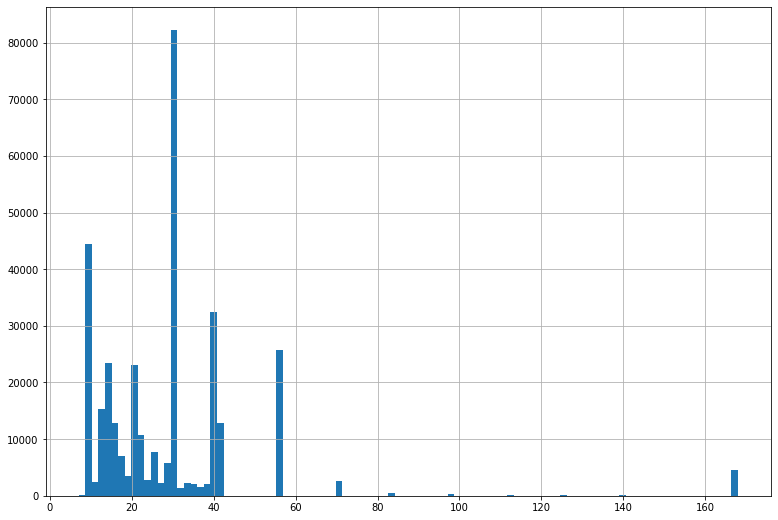

In [41]:
# распределение запрашиваемых сроков займов
display(real_term['term'].describe())
real_term['term'].hist(bins=100, figsize=(13, 9));

count    332380.000000
mean         32.497094
std          39.830470
min           0.000000
25%           8.000000
50%          20.000000
75%          42.000000
max         689.000000
Name: real_term, dtype: float64

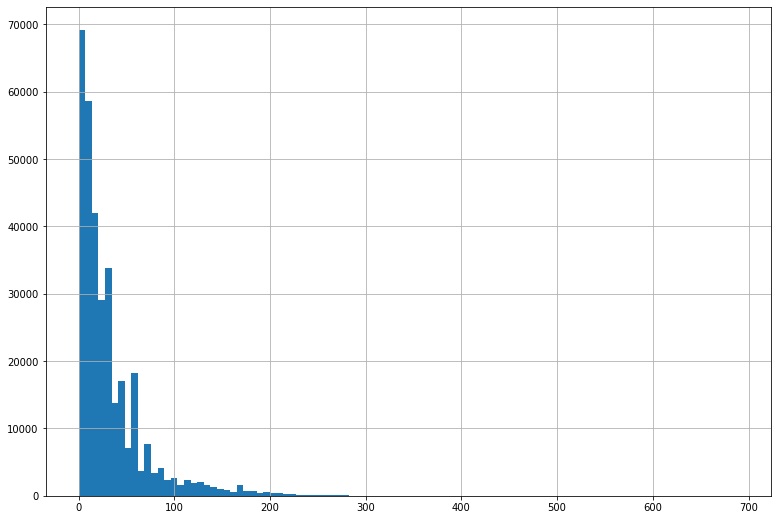

In [42]:
# распределение фактических сроков пользования займом
display(real_term['real_term'].describe())
real_term['real_term'].hist(bins=100, figsize=(13, 9));

In [43]:
# ТОП10 запрашиваемых сроков
real_term['term'].value_counts().head(10)

30    78227
10    44409
40    32414
56    25774
20    17957
15    16517
42    12836
16    12782
12    12482
23     7655
Name: term, dtype: int64

In [44]:
# ТОП10 фактических сроков
real_term['real_term'].value_counts().head(10)

1     12142
0     11770
10    11750
56    11024
2     10208
30    10074
3      9639
42     9096
4      8887
5      8402
Name: real_term, dtype: int64

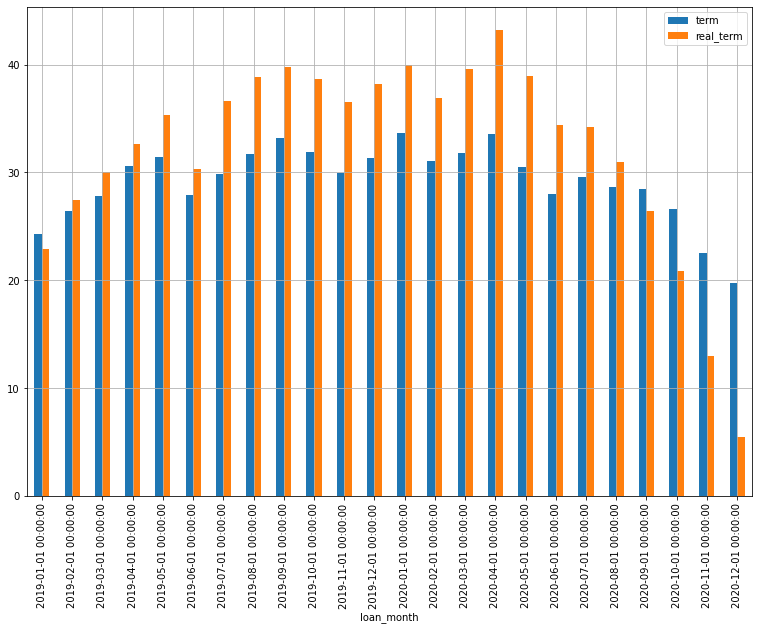

In [45]:
real_term.groupby('loan_month').agg({'term': 'mean', 'real_term': 'mean'}).plot(kind='bar', figsize=(13, 9), grid=True);

#### 6.3 Динамка планового и фактического срока пользования деньгами

<div class="alert alert-block alert-info">
<b>Вывод:</b>
    <ul>
        <li> весь 2019 год средний срок пользовния деньгами показывал положительную динамику
        <li> в этот же период мы видим значительно большой рост факт.пользования отностилеьно плана
        <li> начиная с апреля 2020 график идет вниз, но это скорее всего связано с тем, что часть клиентов из просрочки еще не вернули деньги (но согласно статистике обязательно вернут) либо доля досрочных погашений выросла
        <li> в дальнейшем посомотрим еще на эти показатели в когортах
    </ul>
</div>

### 7. Категоризация займов по реальному сроку пользования деньгами

In [46]:
# созданим функцию категоризации срока закрытия займа
def set_term_category(row):
    if row['real_term'] == row['term']:
        return 'В срок'
    elif row['real_term'] < row['term']:
        return 'Досрочно'
    elif row['real_term'] > row['term']:
        return 'С просрочкой'
    return 'Не закрыт'

In [47]:
# применяем функцию
loans['term_category'] = loans.apply(set_term_category, axis=1)

# проверяем
loans.sample(10)

,cid,start_date,value,term,status,end_date,loan_month,real_term,term_category
243719,3863746,2019-08-25,3210.0,30,Погашен,2019-09-06,2019-08-01,12.0,Досрочно
60994,3052710,2019-02-16,15000.0,30,Погашен,2019-03-11,2019-02-01,23.0,Досрочно
1400,2829423,2019-03-27,7000.0,23,На цессии,NaT,2019-03-01,NaN,Не закрыт
62312,3057697,2019-04-28,4400.0,30,Погашен,2019-05-17,2019-04-01,19.0,Досрочно
297905,4073862,2020-10-02,18000.0,12,Погашен,2020-10-12,2020-10-01,10.0,Досрочно
402066,4462025,2020-12-05,2000.0,12,Погашен,2020-12-14,2020-12-01,9.0,Досрочно
239325,3841373,2019-09-03,8560.0,10,Погашен,2019-09-08,2019-09-01,5.0,Досрочно
377174,4386928,2020-05-26,3450.0,30,Просрочен,NaT,2020-05-01,NaN,Не закрыт
271124,3977262,2019-11-05,10000.0,26,Погашен,2019-11-07,2019-11-01,2.0,Досрочно
178796,3579398,2020-07-15,5750.0,40,Погашен,2020-10-03,2020-07-01,80.0,С просрочкой


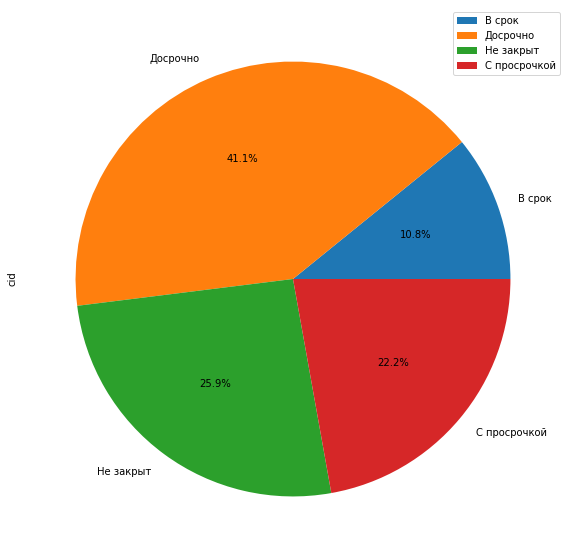

In [48]:
# построим круговую диаграмму для визуализации разделения займов по типам погашения
loans.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

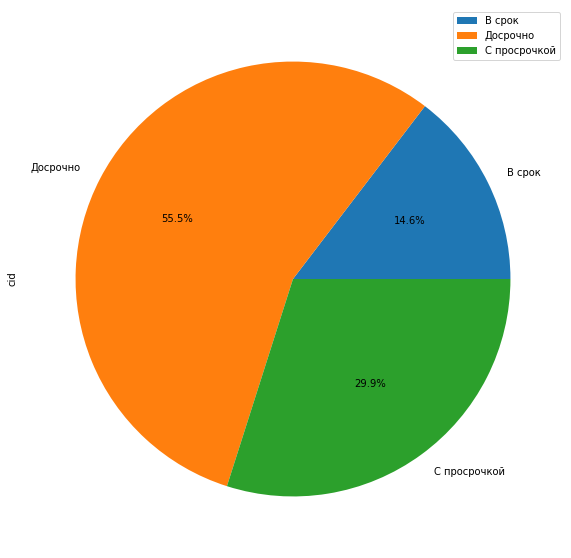

In [49]:
# та же диаграмма, но без статуса "Не закрыт"
loans.query('term_category != "Не закрыт"')\
.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

<div class="alert alert-block alert-info">
<b>Вывод:</b>
    <ul>
        <li> 29.9% не закрытых займов - цифра немного преувеличенная т.к. чем ближе анализируемый месяц к текущему - тем больше % невозвратов и наоборот.
        <li> если анализировать уже закрытые займы - 55.5% досрочно закрытых займов это большая цифра. И это как раз точка роста
    </ul>
</div>

### 8. Исследование суммы займов

#### 8.1 Базовые данные о сумме займов

In [50]:
print(f'Суммарные выдачи за анализируемый период составили {loans["value"].sum().round(0):,} рублей')

Суммарные выдачи за анализируемый период составили 4,335,232,940.0 рублей


In [51]:
# посмотрим на среднее, медиану, квартили и другие значения
loans['value'].describe()

count    448262.000000
mean       9671.203314
std        6748.788683
min        1500.000000
25%        4500.000000
50%        8000.000000
75%       13000.000000
max       80500.000000
Name: value, dtype: float64

In [52]:
# TOP10 частотность
loans['value'].value_counts().head(10)

8000.0     30589
10000.0    26879
4000.0     19368
5000.0     17059
12000.0    15628
3000.0     15424
2000.0     14507
6500.0     10270
3500.0      9518
15000.0     8811
Name: value, dtype: int64

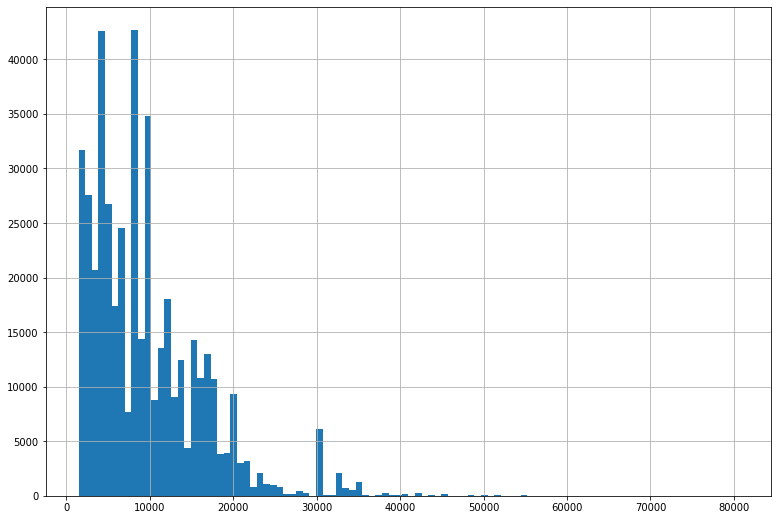

In [53]:
# посмотрим на распределение
loans['value'].hist(figsize=(13, 9), bins=100);

<div class="alert alert-block alert-info">
<b>Вывод:</b>
    <ul>
        <li> общая сумма выданных средств за анализируемый период 4 335 232 940 рубля(ей)
        <li> средняя выдача - 9671 рублей
        <li> первый-третий квартили: 4500, 8000, 13000
        <li> чаще всего берут займ на 8000 рублей (30589 раз)
        <li> в ТОП10 значений по частоте 70% менее 10000 рублей
    </ul>
</div>

#### 8.2 Динамика измениня средней суммы займа

In [54]:
# группируем данные по месяцам, для каждого месяца считаем суммарный объем займов и количество займов
avg_loan_value = loans.groupby('loan_month').agg({'value': 'sum', 'cid': 'count'})

# переименуюем столбцы
avg_loan_value.columns=['total_value', 'total_loans']

# посчитаем средний чек
avg_loan_value['avg_loan_value'] = (avg_loan_value['total_value'] / avg_loan_value['total_loans']).astype('int')

avg_loan_value

,total_value,total_loans,avg_loan_value
loan_month,,,
2019-01-01,74823900.0,9157,8171
2019-02-01,114811600.0,13419,8555
2019-03-01,186953800.0,20770,9001
2019-04-01,228119200.0,23864,9559
2019-05-01,172281916.0,16360,10530
2019-06-01,126582760.0,13091,9669
2019-07-01,190280035.0,19330,9843
2019-08-01,203977264.0,19683,10363
2019-09-01,140698429.0,13197,10661


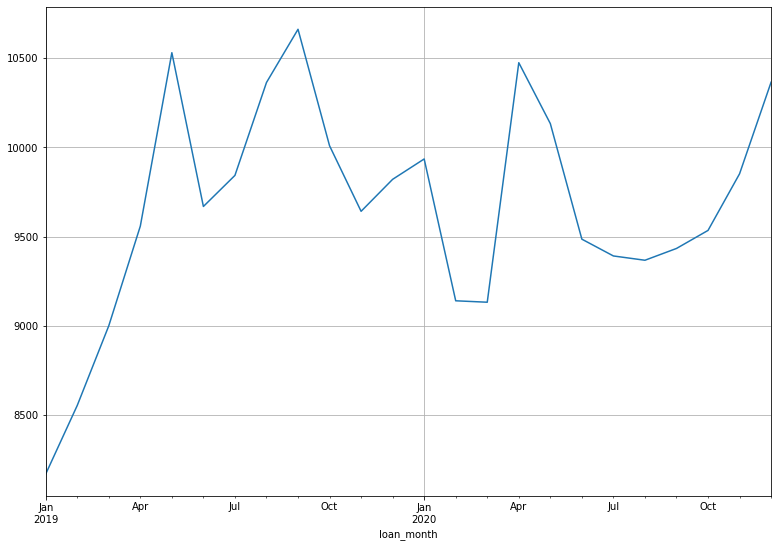

In [55]:
# посмотрим на чек в динамике
avg_loan_value['avg_loan_value'].plot(figsize=(13, 9), grid=True);

In [56]:
print(f'Минимальное значение {avg_loan_value["avg_loan_value"].min()} рубл.')
print(f'Максимальное занчение {avg_loan_value["avg_loan_value"].max()} руб.')

Минимальное значение 8171 рубл.
Максимальное занчение 10661 руб.


<div class="alert alert-block alert-info">
<b>Вывод:</b>
    <ul>
        <li> мин-макс средние значения находятся в диапазоне от 8171 руб до 10661 руб
        <li> не прослеживается какой-либо тренд на рост-падение, наблюдаюется рост-падение чека на 2-3к рублей
    </ul>
</div>

### 9. Когортный анализ

#### 9.1 Ретеншен

In [57]:
# для начала нам нужно выделить в отдельную таблицу месяц первого займа для каждого пользователя
loan_first_month = loans.sort_values(by=['cid', 'loan_month']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# переименуем столбцы
loan_first_month.columns = ['cid', 'loan_first_month']

# смотрим на результат
loan_first_month

,cid,loan_first_month
0,2825209,2019-01-01
1,2825218,2019-01-01
2,2825225,2019-03-01
3,2825230,2020-09-01
4,2825232,2019-07-01
...,...,...
186960,4706283,2020-11-01
186961,4706308,2020-12-01
186962,4706310,2020-12-01
186963,4706332,2020-11-01


In [58]:
# объеденим таблицы loans vs loan_first_month
loans = pd.merge(loans, loan_first_month, on='cid')

# добавим в таблицу столбец cohort_lifetime, который указывает на срок жизни когорты в месяцах
loans['cohort_lifetime'] =((loans['loan_month'] - loans['loan_first_month']) / np.timedelta64(1,'M'))\
.round().astype('int')

# смотрим на результат
loans.head()

,cid,start_date,value,term,status,end_date,loan_month,real_term,term_category,loan_first_month,cohort_lifetime
0,2825498,2019-08-20,30000.0,168,Погашен,2019-12-10,2019-08-01,112.0,Досрочно,2019-01-01,7
1,2825498,2019-01-03,4000.0,20,Погашен,2019-01-06,2019-01-01,3.0,Досрочно,2019-01-01,0
2,2825498,2020-05-29,19000.0,56,Погашен,2020-06-11,2020-05-01,13.0,Досрочно,2019-01-01,16
3,2825498,2019-01-22,4000.0,20,Погашен,2019-02-05,2019-01-01,14.0,Досрочно,2019-01-01,0
4,2825498,2019-02-10,6500.0,30,Погашен,2019-02-27,2019-02-01,17.0,Досрочно,2019-01-01,1


In [59]:
# создадим новую таблицу retention и сгруппируем в нее данные из таблицы loans
retention = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'nunique'}).reset_index()

# переименуем колонки
retention.columns = ['loan_first_month', 'cohort_lifetime', 'active_users']

# смотрим результат
retention

,loan_first_month,cohort_lifetime,active_users
0,2019-01-01,0,7957
1,2019-01-01,1,2896
2,2019-01-01,2,2119
3,2019-01-01,3,1385
4,2019-01-01,4,682
...,...,...,...
295,2020-10-01,1,2710
296,2020-10-01,2,1777
297,2020-11-01,0,10219
298,2020-11-01,1,2192


In [60]:
# теперь в отдельной таблице сохраним пользователей нулевой когорты
initial_users = retention[retention['cohort_lifetime'] == 0][['loan_first_month', 'active_users']]

# переименуем столбцы
initial_users.columns = ['loan_first_month', 'initial_users']

# смотрим результат
initial_users

,loan_first_month,initial_users
0,2019-01-01,7957
24,2019-02-01,8879
47,2019-03-01,12222
69,2019-04-01,13328
90,2019-05-01,7258
110,2019-06-01,4995
129,2019-07-01,10059
147,2019-08-01,8585
164,2019-09-01,4140
180,2019-10-01,6106


In [61]:
# добавим в таблицу retention столбец initial_users из таблицы initial_users
retention = pd.merge(retention, initial_users, on='loan_first_month')

# рассчитаем retention_rate
retention['retention_rate'] = retention['active_users'] / retention['initial_users']

# смотрим финальную таблицу
retention.head()

,loan_first_month,cohort_lifetime,active_users,initial_users,retention_rate
0,2019-01-01,0,7957,7957,1.000000
1,2019-01-01,1,2896,7957,0.363956
2,2019-01-01,2,2119,7957,0.266306
3,2019-01-01,3,1385,7957,0.174061
4,2019-01-01,4,682,7957,0.085711


In [62]:
# группируем все в сводную таблицу
retention_pivot = retention.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                                        values='retention_rate', aggfunc='sum')

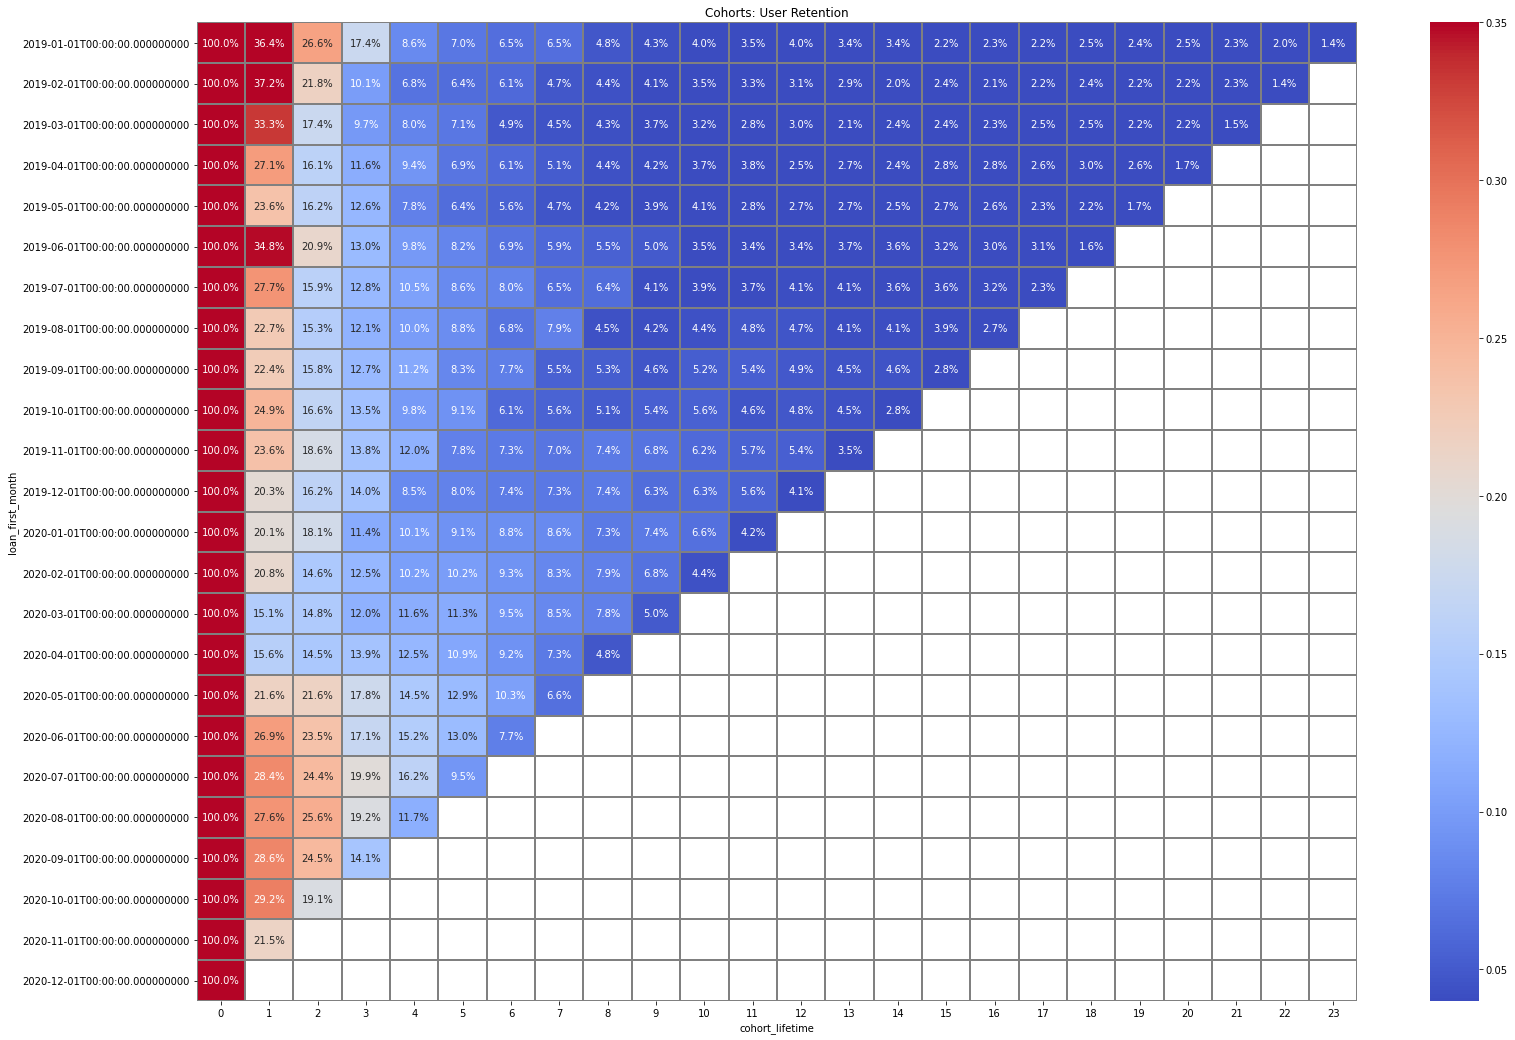

In [63]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmax=0.35, vmin=0.04);

<div class="alert alert-block alert-info">
<b>Вывод:</b>
    <ul>
        <li> начало 2019 года имеет одни из самых лучших показателей
        <li> затем, начиная как раз с декабря 2019 показатели постепенно становтся хуже и дотигают минимальных значений к марту-апрелю 2020.
        <li> есть 2 вариант: корона и/или ухудшающиемя для клиентов условия
    </ul>
</div>

#### 9.2 Среднее кол-во займов

In [64]:
avg_loan_amount = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).reset_index()
avg_loan_amount.rename(columns={'cid': 'cumsum_loans'}, inplace=True)
avg_loan_amount = pd.merge(avg_loan_amount, initial_users, on='loan_first_month')
avg_loan_amount['avg_loans'] = (avg_loan_amount['cumsum_loans'] / avg_loan_amount['initial_users']).round(2)

avg_loan_amount.head()

,loan_first_month,cohort_lifetime,cumsum_loans,initial_users,avg_loans
0,2019-01-01,0,9157,7957,1.15
1,2019-01-01,1,3497,7957,0.44
2,2019-01-01,2,2663,7957,0.33
3,2019-01-01,3,1658,7957,0.21
4,2019-01-01,4,771,7957,0.10


In [65]:
avg_loan_pivot = avg_loan_amount.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                                             values='avg_loans', aggfunc='mean').cumsum(axis=1)

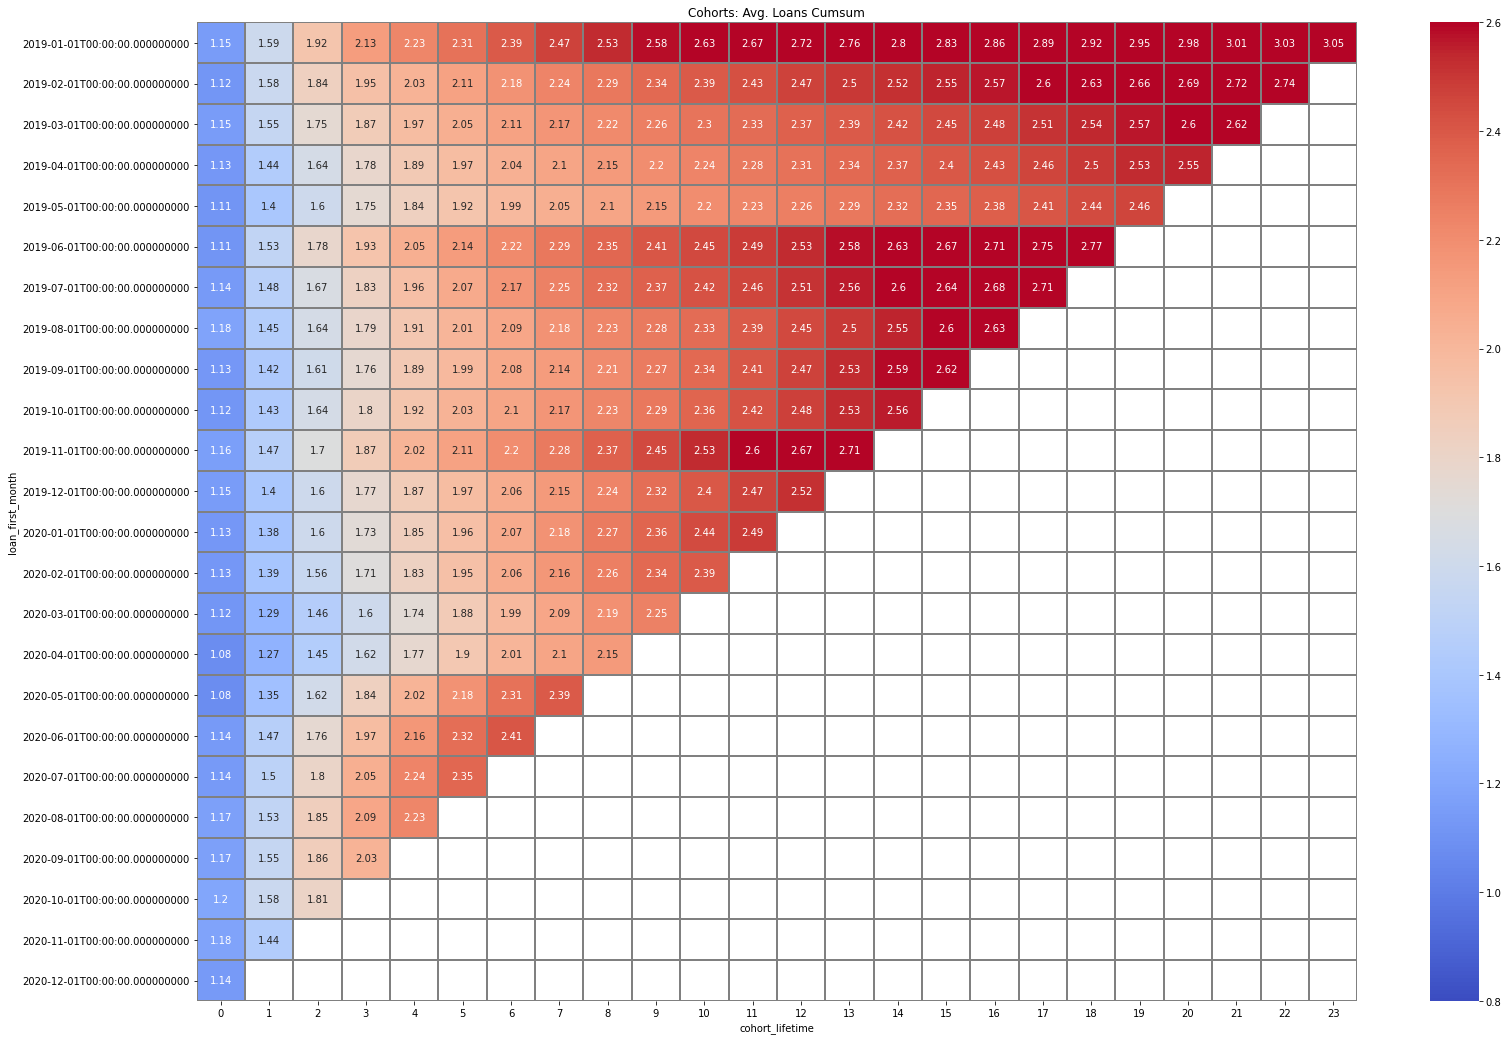

In [66]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Avg. Loans Cumsum')
sns.heatmap(avg_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.8, vmax=2.6);

#### 9.3 ARPU (Average Revenue per User)

In [67]:
# данные в таблице указаны в тысячах рублей
arpu = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum'}).reset_index()
arpu = pd.merge(arpu, initial_users, on='loan_first_month')
arpu['arpu'] = ((arpu['value'] / arpu['initial_users'])/1000).round(2)

arpu.head()

,loan_first_month,cohort_lifetime,value,initial_users,arpu
0,2019-01-01,0,74823900.0,7957,9.40
1,2019-01-01,1,35037100.0,7957,4.40
2,2019-01-01,2,27916300.0,7957,3.51
3,2019-01-01,3,21167100.0,7957,2.66
4,2019-01-01,4,10443336.2,7957,1.31


In [68]:
arpu_pivot = arpu.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='arpu', aggfunc='mean').cumsum(axis=1)

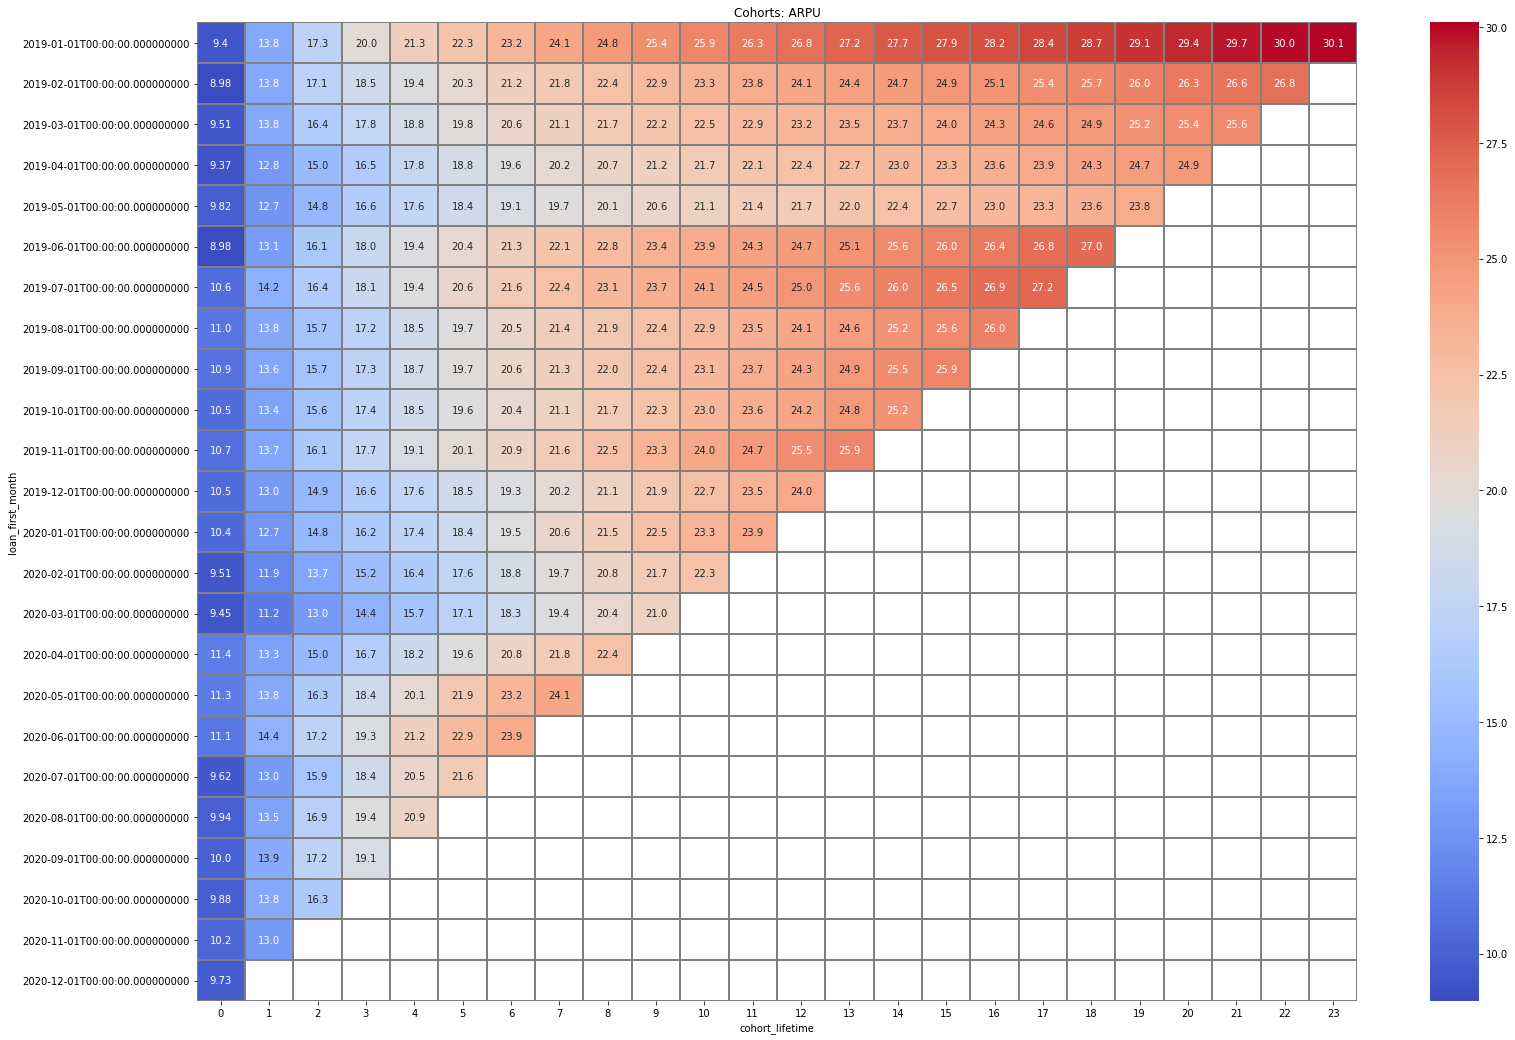

In [69]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: ARPU')
sns.heatmap(arpu_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm');

#### 5.4 Средняя сумма займа в конкретный месяц
почему с ростом lifetime "чек" не растет?

In [70]:
# сумма займов делится на количество займов
avg_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'}).reset_index()
avg_loan_value['avg_loan_value'] = ((avg_loan_value['value'] / avg_loan_value['cid'])/1000).round(2)

avg_loan_value.head()

,loan_first_month,cohort_lifetime,value,cid,avg_loan_value
0,2019-01-01,0,74823900.0,9157,8.17
1,2019-01-01,1,35037100.0,3497,10.02
2,2019-01-01,2,27916300.0,2663,10.48
3,2019-01-01,3,21167100.0,1658,12.77
4,2019-01-01,4,10443336.2,771,13.55


In [71]:
avg_loan_value_pivot = avg_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_loan_value', aggfunc='mean')

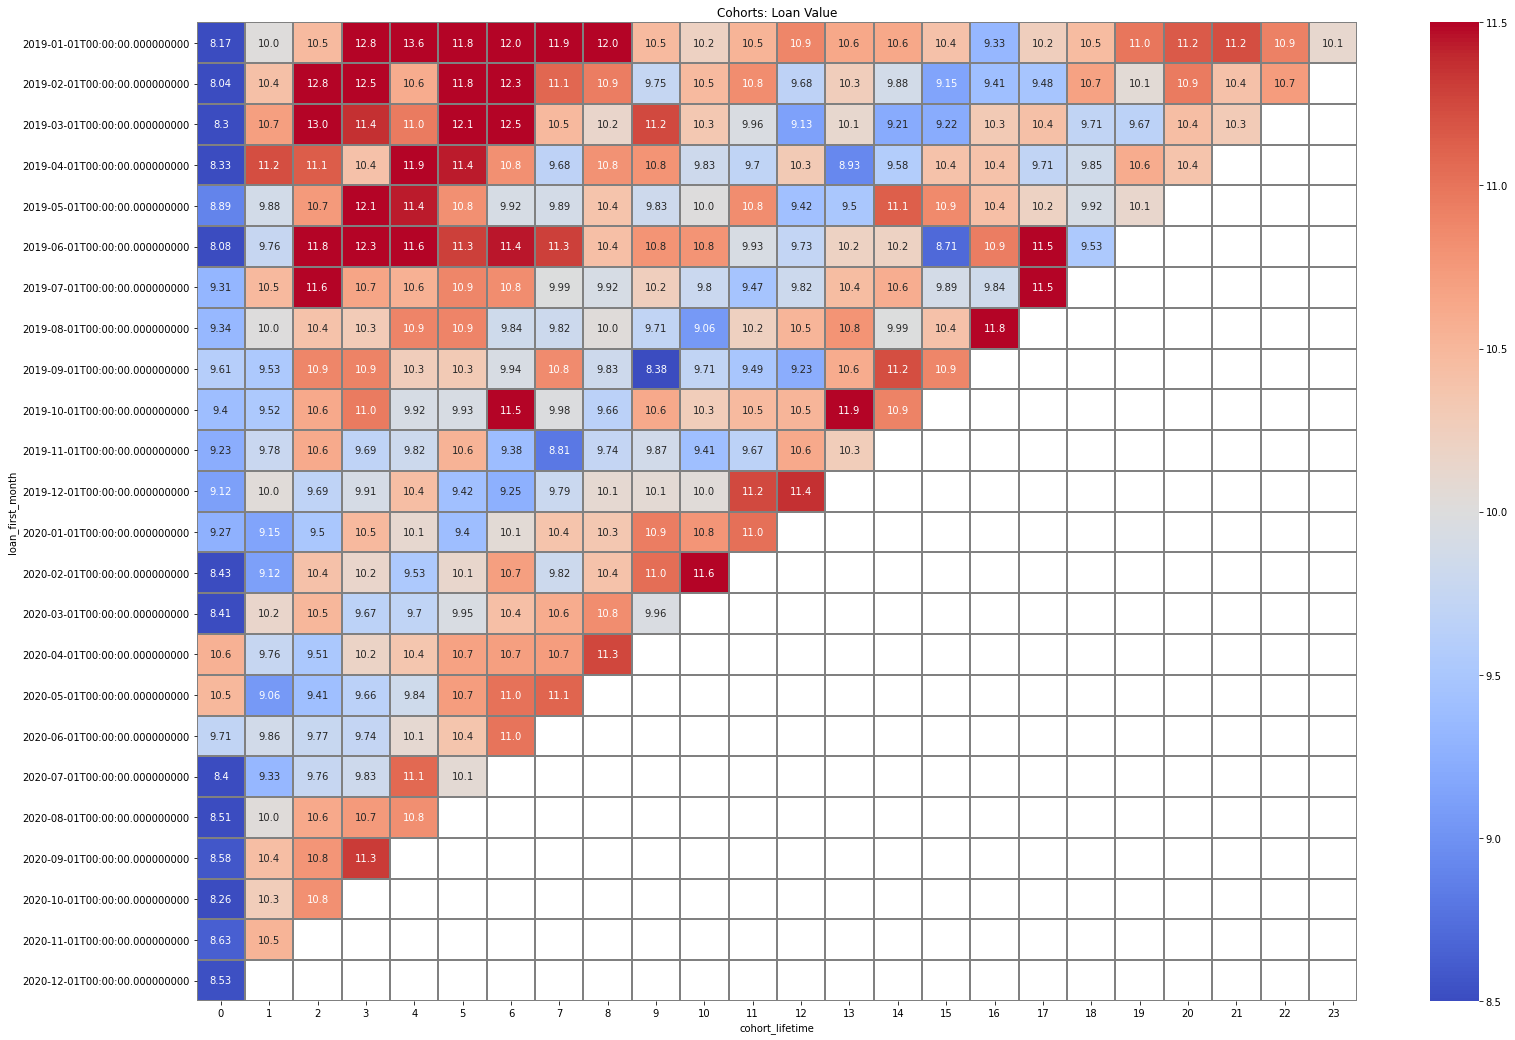

In [72]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_loan_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=8.5, vmax=11.5);

#### 9.4 Средняя сумма займа накопительным итогом

In [73]:
# сумма займов накопительным итогом делится на кол-во уникальных клиентов в когорте 0
avg_cumsum_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'})\
.groupby(level=0).cumsum().reset_index()
avg_cumsum_loan_value.rename(columns={'value': 'cumsum_value', 'cid': 'cumsum_loans'}, inplace=True)
avg_cumsum_loan_value['avg_cumsum_loan_value'] = ((avg_cumsum_loan_value['cumsum_value'] / avg_cumsum_loan_value['cumsum_loans'])/1000).round(2)

avg_cumsum_loan_value.head()

,loan_first_month,cohort_lifetime,cumsum_value,cumsum_loans,avg_cumsum_loan_value
0,2019-01-01,0,74823900.0,9157,8.17
1,2019-01-01,1,109861000.0,12654,8.68
2,2019-01-01,2,137777300.0,15317,9.00
3,2019-01-01,3,158944400.0,16975,9.36
4,2019-01-01,4,169387736.2,17746,9.55


In [74]:
avg_cumsum_loan_pivot = avg_cumsum_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_cumsum_loan_value', aggfunc='mean')

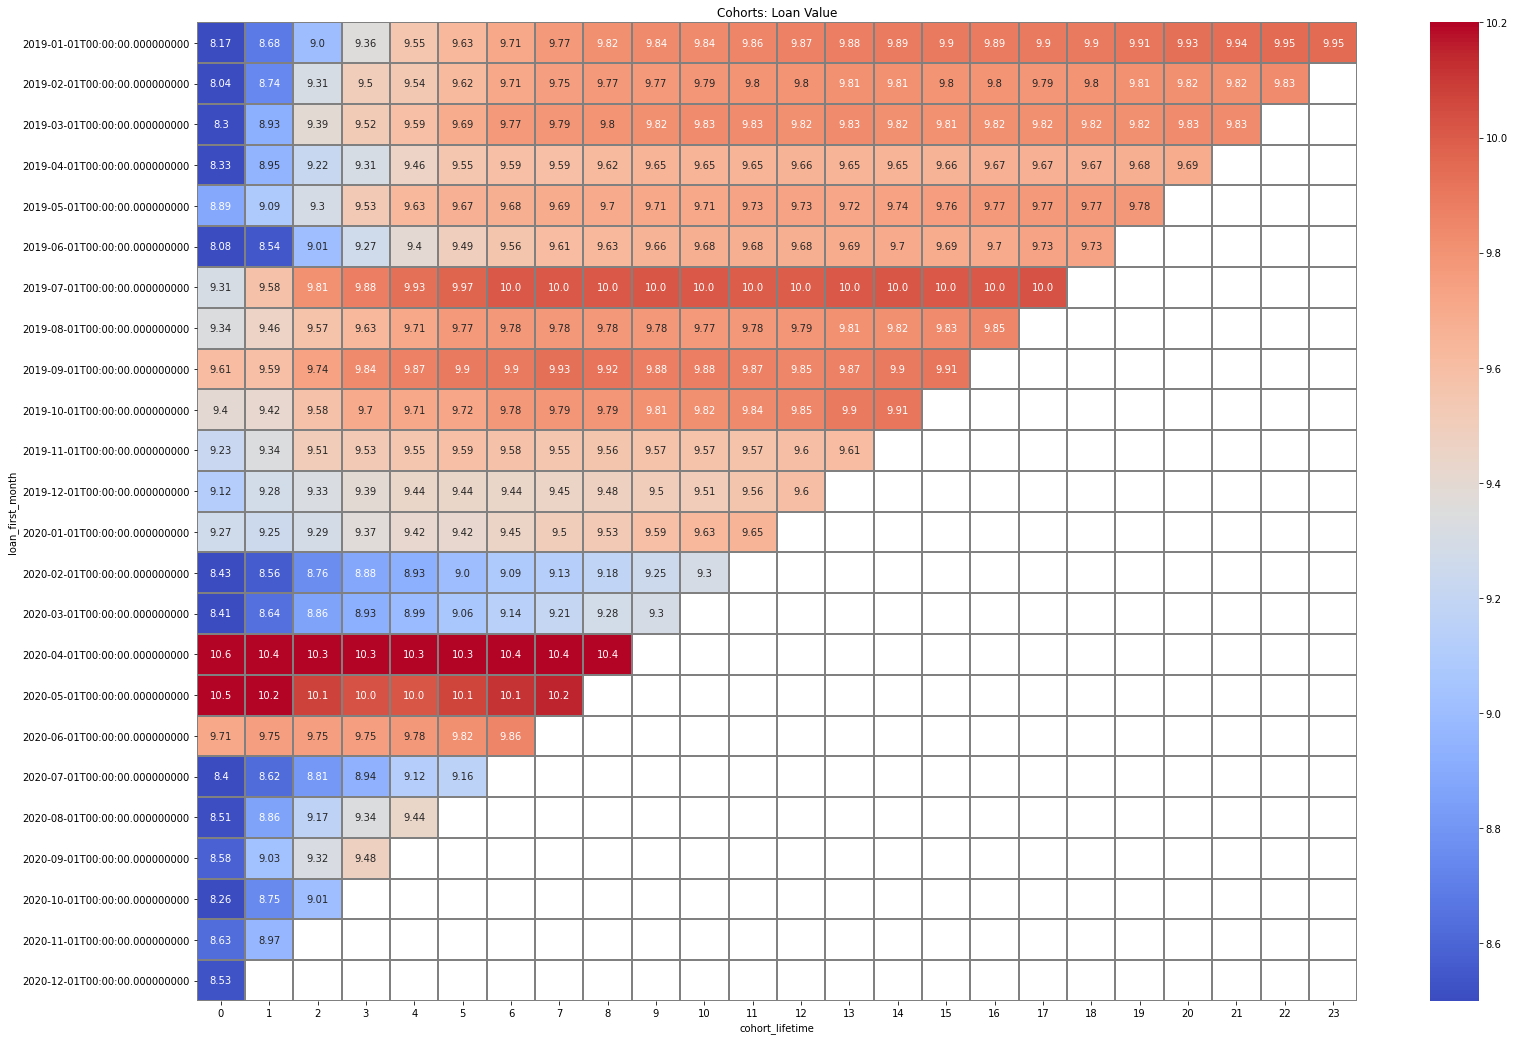

In [75]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_cumsum_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=8.5, vmax=10.2);

#### 9.5 Оборотка нарастающим итогом

In [76]:
# данные в таблице указаны в миллионах рублей
cumsum_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', }).reset_index()
cumsum_value['value'] = (cumsum_value['value'] / 10000000).round(2)

cumsum_value

,loan_first_month,cohort_lifetime,value
0,2019-01-01,0,7.48
1,2019-01-01,1,3.50
2,2019-01-01,2,2.79
3,2019-01-01,3,2.12
4,2019-01-01,4,1.04
...,...,...,...
295,2020-10-01,1,3.65
296,2020-10-01,2,2.28
297,2020-11-01,0,10.45
298,2020-11-01,1,2.78


In [77]:
initial_value = cumsum_value[cumsum_value['cohort_lifetime'] == 0][['loan_first_month', 'value']]
initial_value.columns=['loan_first_month', 'initial_value']
initial_value

,loan_first_month,initial_value
0,2019-01-01,7.48
24,2019-02-01,7.98
47,2019-03-01,11.62
69,2019-04-01,12.49
90,2019-05-01,7.13
110,2019-06-01,4.49
129,2019-07-01,10.68
147,2019-08-01,9.45
164,2019-09-01,4.50
180,2019-10-01,6.41


In [78]:
cumsum_value = pd.merge(cumsum_value, initial_value, on='loan_first_month')
cumsum_value['value_gain'] = cumsum_value['value'] / cumsum_value['initial_value']

cumsum_value.head(20)

,loan_first_month,cohort_lifetime,value,initial_value,value_gain
0,2019-01-01,0,7.48,7.48,1.000000
1,2019-01-01,1,3.50,7.48,0.467914
2,2019-01-01,2,2.79,7.48,0.372995
3,2019-01-01,3,2.12,7.48,0.283422
4,2019-01-01,4,1.04,7.48,0.139037
5,2019-01-01,5,0.78,7.48,0.104278
6,2019-01-01,6,0.75,7.48,0.100267
7,2019-01-01,7,0.74,7.48,0.098930
8,2019-01-01,8,0.54,7.48,0.072193
9,2019-01-01,9,0.45,7.48,0.060160


In [79]:
cumsum_value_pivot = cumsum_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                         values='value_gain', aggfunc='mean').cumsum(axis=1)

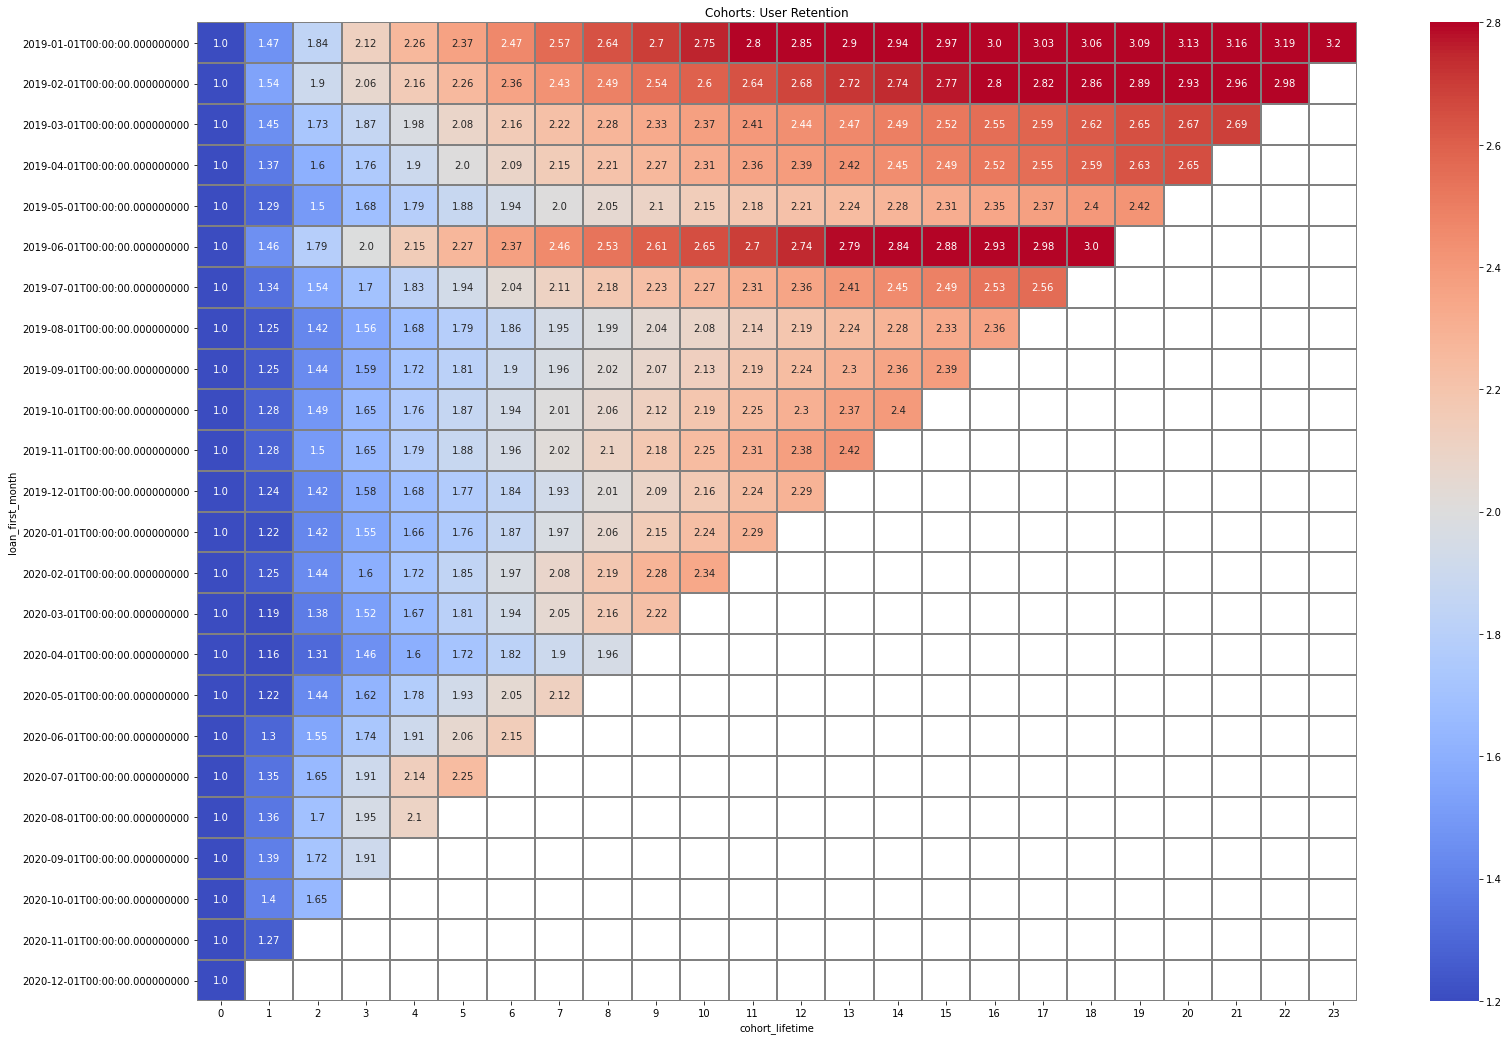

In [80]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(cumsum_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=1.2, vmax=2.8);

#### 9.6 NPL "наоборот"

In [81]:
loans['end_month'] = loans['end_date'].astype('datetime64[M]')
loans.head()

,cid,start_date,value,term,status,end_date,loan_month,real_term,term_category,loan_first_month,cohort_lifetime,end_month
0,2825498,2019-08-20,30000.0,168,Погашен,2019-12-10,2019-08-01,112.0,Досрочно,2019-01-01,7,2019-12-01
1,2825498,2019-01-03,4000.0,20,Погашен,2019-01-06,2019-01-01,3.0,Досрочно,2019-01-01,0,2019-01-01
2,2825498,2020-05-29,19000.0,56,Погашен,2020-06-11,2020-05-01,13.0,Досрочно,2019-01-01,16,2020-06-01
3,2825498,2019-01-22,4000.0,20,Погашен,2019-02-05,2019-01-01,14.0,Досрочно,2019-01-01,0,2019-02-01
4,2825498,2019-02-10,6500.0,30,Погашен,2019-02-27,2019-02-01,17.0,Досрочно,2019-01-01,1,2019-02-01


In [82]:
get_loans = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
get_loans.rename(columns={'cid': 'get_loans'}, inplace=True)
get_loans.head()

,loan_first_month,cohort_lifetime,get_loans
0,2019-01-01,0,9157
1,2019-01-01,1,12654
2,2019-01-01,2,15317
3,2019-01-01,3,16975
4,2019-01-01,4,17746


In [83]:
paid_loans = loans.groupby(['loan_first_month', 'end_month']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
paid_loans['cohort_lifetime'] = ((paid_loans['end_month'] - paid_loans['loan_first_month']) / np.timedelta64(1,'M')).round().astype('int')
paid_loans.drop(columns='end_month', inplace=True)
paid_loans = paid_loans[['loan_first_month', 'cohort_lifetime', 'cid']]
paid_loans.rename(columns={'cid': 'paid_loans'}, inplace=True)

paid_loans.head()

,loan_first_month,cohort_lifetime,paid_loans
0,2019-01-01,0,2489
1,2019-01-01,1,7488
2,2019-01-01,2,10002
3,2019-01-01,3,11632
4,2019-01-01,4,12569


In [84]:
output = pd.merge(get_loans, paid_loans, on=['loan_first_month', 'cohort_lifetime'])
output['r_rate'] = (output['paid_loans'] / output['get_loans'])
output_pivot = output.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='r_rate')

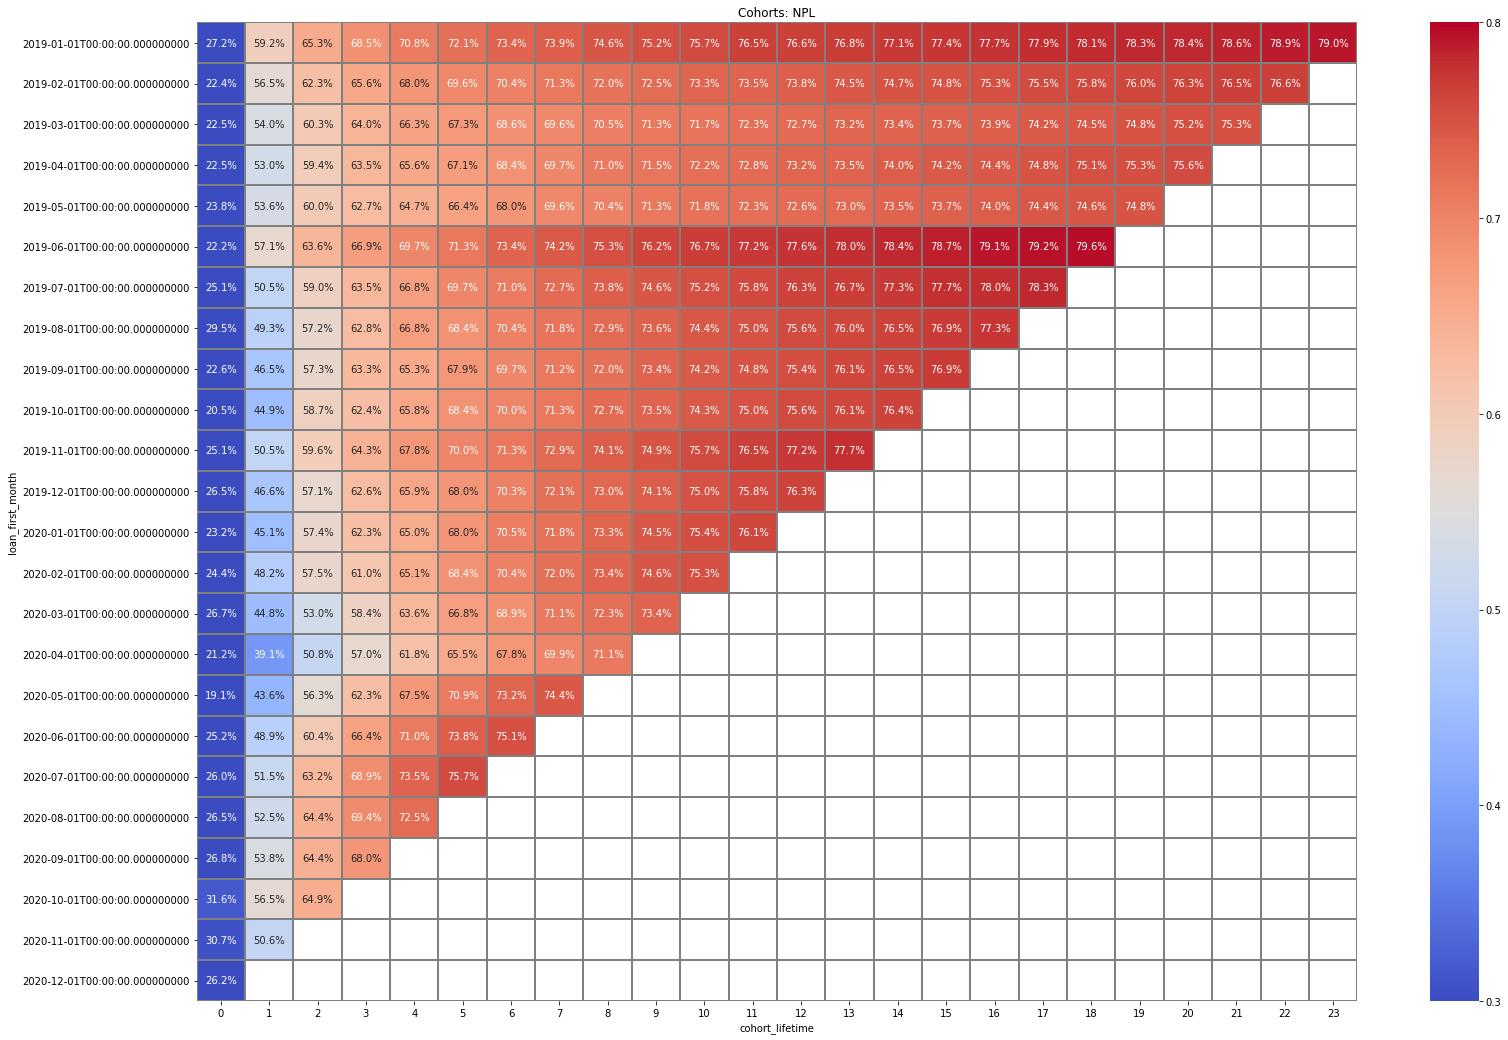

In [85]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: NPL')
sns.heatmap(output_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.3, vmax=0.80);

#### 5.7 Накопительное среднее количество дней пользование кредитом на уникального клиента

In [86]:
rt = loans.groupby(by=['loan_first_month', 'cohort_lifetime']).agg({'real_term': 'sum'}).reset_index()
rt

,loan_first_month,cohort_lifetime,real_term
0,2019-01-01,0,161760.0
1,2019-01-01,1,76559.0
2,2019-01-01,2,64747.0
3,2019-01-01,3,50862.0
4,2019-01-01,4,25974.0
...,...,...,...
295,2020-10-01,1,27724.0
296,2020-10-01,2,2938.0
297,2020-11-01,0,85059.0
298,2020-11-01,1,4112.0


In [87]:
rt_merge = pd.merge(rt, initial_users, how='left', on='loan_first_month')
rt_merge['avg_days'] = rt_merge['real_term'] / rt_merge['initial_users']
rt_merge

,loan_first_month,cohort_lifetime,real_term,initial_users,avg_days
0,2019-01-01,0,161760.0,7957,20.329270
1,2019-01-01,1,76559.0,7957,9.621591
2,2019-01-01,2,64747.0,7957,8.137112
3,2019-01-01,3,50862.0,7957,6.392108
4,2019-01-01,4,25974.0,7957,3.264296
...,...,...,...,...,...
295,2020-10-01,1,27724.0,9291,2.983963
296,2020-10-01,2,2938.0,9291,0.316220
297,2020-11-01,0,85059.0,10219,8.323613
298,2020-11-01,1,4112.0,10219,0.402388


In [88]:
rt_pivot = rt_merge.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='avg_days').cumsum(axis=1)

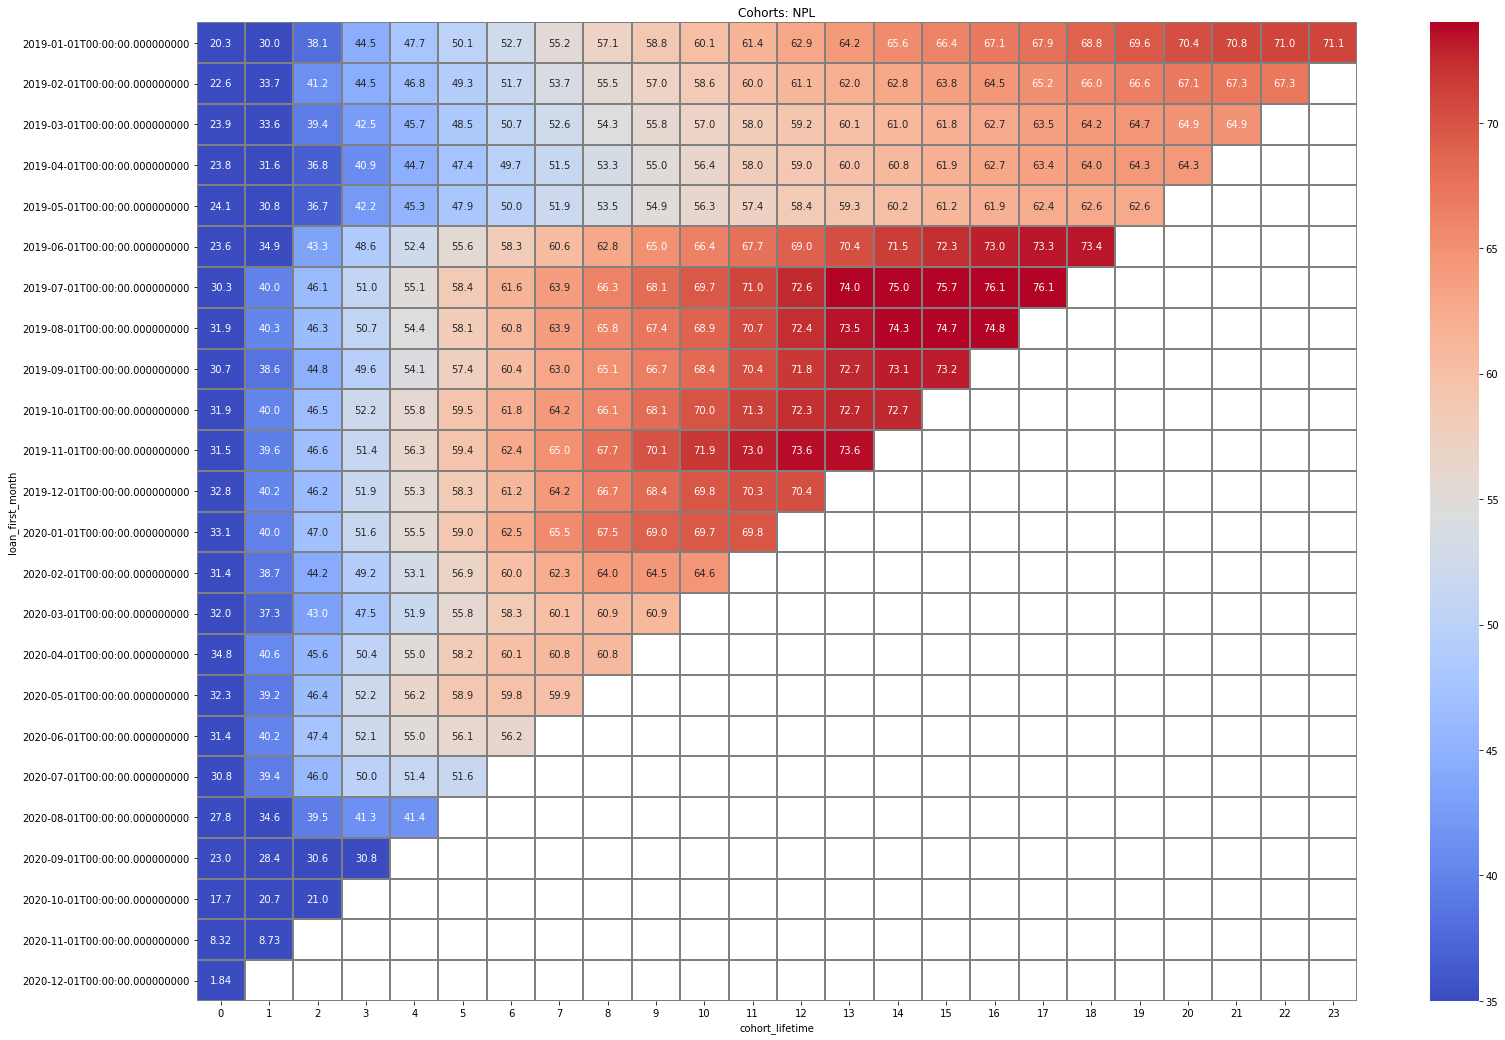

In [89]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: NPL')
sns.heatmap(rt_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=35, vmax=74);

In [90]:
loyalty = loans[loans['end_date'].notna()]
loyalty['money'] = (loyalty['value'] * loyalty['real_term']) / 100
loyalty = loyalty.groupby(by='cid').agg({'start_date': 'count', 'value': 'sum', 'real_term': 'sum', 'money': 'sum'})
loyalty.columns=['loans', 'value', 'active_days', 'revenue']

In [91]:
loyalty.query('active_days >= 50 and active_days < 90').sort_values(by='revenue', ascending=False).head(10)

,loans,value,active_days,revenue
cid,,,,
4560430,1,80500.0,86.0,69230.0
3722579,1,55000.0,70.0,38500.0
4515413,2,52900.0,87.0,36984.0
4487564,4,76300.0,84.0,34420.0
4265184,3,99000.0,80.0,32250.0
4036754,2,62000.0,70.0,31500.0
4534720,3,94000.0,69.0,31220.0
3051576,1,35000.0,84.0,29400.0
3705848,1,33000.0,89.0,29370.0


In [92]:
loyalty.query('active_days >= 50 and active_days < 90').sort_values(by='revenue', ascending=False).tail(10)

,loans,value,active_days,revenue
cid,,,,
4482992,2,4085.0,50.0,955.7
4514036,1,1700.0,56.0,952.0
4502626,1,1900.0,50.0,950.0
4288092,1,1900.0,50.0,950.0
4533661,3,5555.0,50.0,930.5
4486123,3,5300.0,50.0,922.0
4156600,2,3400.0,53.0,901.0
3816091,1,1700.0,53.0,901.0
4394247,1,1725.0,52.0,897.0


In [93]:
loyalty.query('active_days >= 50 and active_days < 90').sort_values(by='revenue', ascending=False).sample(10)

,loans,value,active_days,revenue
cid,,,,
3827181,1,16000.0,73.0,11680.0
4295701,1,7500.0,79.0,5925.0
3605492,2,13500.0,59.0,3040.0
3701353,5,53550.0,52.0,7779.0
4395801,3,19000.0,84.0,8180.0
3809946,1,9990.0,57.0,5694.3
3905512,2,22500.0,72.0,9970.0
4093901,5,15000.0,71.0,2190.0
3340686,2,29000.0,81.0,11745.0


In [94]:
loyalty.query('active_days >= 50 and active_days < 90').describe()

,loans,value,active_days,revenue
count,27698.000000,27698.000000,27698.000000,27698.000000
mean,2.359773,20914.609611,67.028486,6891.120456
std,1.866968,18456.222753,11.449771,3880.936577
min,1.000000,1500.000000,50.000000,780.000000
25%,1.000000,10000.000000,56.000000,4035.340000
50%,2.000000,16000.000000,66.000000,6200.000000
75%,3.000000,25883.750000,76.000000,9000.000000
max,54.000000,630354.000000,89.000000,69230.000000


In [95]:
loyalty.corr()

,loans,value,active_days,revenue
loans,1.000000,0.778667,0.500724,0.350950
value,0.778667,1.000000,0.549641,0.617759
active_days,0.500724,0.549641,1.000000,0.823371
revenue,0.350950,0.617759,0.823371,1.000000


In [96]:
loyalty.query('active_days >= 50 and active_days < 90').corr()

,loans,value,active_days,revenue
loans,1.000000,0.698420,0.147651,-0.067794
value,0.698420,1.000000,0.142352,0.459866
active_days,0.147651,0.142352,1.000000,0.339190
revenue,-0.067794,0.459866,0.339190,1.000000


In [97]:
result = hg.pettitt_test(loyalty.query('active_days >= 50 and active_days < 90')['revenue'])
print(result)

Pettitt_Test(h=True, cp=10107, p=0.0, U=16217905.0, avg=mean(mu1=6544.414402097556, mu2=7090.322212495026))
